In [1]:
import plt
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd

df_actors = pd.read_csv('../Datasets/IMDB/actorfilms.csv', low_memory=False)
df_actors = df_actors[pd.to_numeric(df_actors['Year'], errors='coerce') >= 1990]

We took this dataset from IMDB. From this we can see in which films actors were in. We can see the actor's id, movie, the year that movie was released, the ratings and the filmid of the movie.

In [3]:
df_actors

Actor    ActorID                            Film  Year  \
39            Lauren Bacall  nm0000002              Ernest & Celestine  2012   
40            Lauren Bacall  nm0000002                      The Forger  2012   
41            Lauren Bacall  nm0000002                      All at Sea  2010   
42            Lauren Bacall  nm0000002                      The Walker  2007   
43            Lauren Bacall  nm0000002                       Manderlay  2005   
...                     ...        ...                             ...   ...   
191868  Roman Griffin Davis  nm9877392                     Jojo Rabbit  2019   
191869            Lexi Rabe  nm9962642                       Silk Road  2021   
191870            Lexi Rabe  nm9962642               Avengers: Endgame  2019   
191871            Lexi Rabe  nm9962642  Godzilla: King of the Monsters  2019   
191872      Inde Navarrette  nm9984699                   Wander Darkly  2020   

         Votes  Rating     FilmID  
39       18793     7.9  tt1816518  
40        4472     5.4  tt1368858  
41         110     5.7  tt0858500  
42        5256     5.8  tt0783608  
43       22622     7.3  tt0342735  
...        ...     ...        ...  
191868  310904     7.9  tt2584384  
191869    2050     5.9  tt7937254  
191870  849079     8.4  tt4154796  
191871  146737     6.0  tt3741700  
191872     776     5.8  tt8902978  

[145601 rows x 7 columns]

In [4]:
actors_set = set(df_actors['Actor'].tolist())

In [5]:
print("We have " +str(len(actors_set)) + " actors in the df_actors dataset.")

We have 9134 actors in the df_actors dataset.


We will cut out actors who had their first movies before 1980, because we wanted to work with more up-to-date actors.

In [6]:
from Artist_Director_Graph.actor_director_functions import cut_off_actors_whose_first_movie_was_before_1980

# cut out actors whose first film was before 1980

actors_after_1980 = cut_off_actors_whose_first_movie_was_before_1980(actors_set, df_actors)

In [7]:
#We will work with this many actors
print(f"We will only work with {len(actors_after_1980)} actors")

We will only work with 9134 actors


This dataframe contains IMDb ids of movie title's with director ids and writer ids. We will only work with the movies and directors from this df_movie_directors dataset.

In [8]:
df_movie_directors = pd.read_csv('../Datasets/IMDB/title.crew.tsv', sep='\t', low_memory=False)

In [9]:
df_movie_directors

tconst   directors  \
0         tt0000001   nm0005690   
1         tt0000002   nm0721526   
2         tt0000003   nm0721526   
3         tt0000004   nm0721526   
4         tt0000005   nm0005690   
...             ...         ...   
12048914  tt9916848   nm1485677   
12048915  tt9916850   nm1485677   
12048916  tt9916852   nm1485677   
12048917  tt9916856  nm10538645   
12048918  tt9916880   nm0996406   

                                                    writers  
0                                                        \N  
1                                                        \N  
2                                                 nm0721526  
3                                                        \N  
4                                                        \N  
...                                                     ...  
12048914  nm9187127,nm1485677,nm9826385,nm9299459,nm1628284  
12048915            nm9187127,nm1485677,nm9826385,nm1628284  
12048916  nm9187127,nm1485677,nm9826385,nm9299459,nm1628284  
12048917                                          nm6951431  
12048918                                nm1482639,nm2586970  

[12048919 rows x 3 columns]

This df_name_to_id dataset maps together people ids (e.g. directors, writers, actors) to their names.

In [10]:
df_name_to_id = pd.read_csv('../Datasets/IMDB/name.basics.tsv', sep='\t', low_memory=False)

In [11]:
df_name_to_id

nconst         primaryName birthYear deathYear  \
0         nm0000001        Fred Astaire      1899      1987   
1         nm0000002       Lauren Bacall      1924      2014   
2         nm0000003     Brigitte Bardot      1934        \N   
3         nm0000004        John Belushi      1949      1982   
4         nm0000005      Ingmar Bergman      1918      2007   
...             ...                 ...       ...       ...   
14859444  nm9993714   Romeo del Rosario        \N        \N   
14859445  nm9993716       Essias Loberg        \N        \N   
14859446  nm9993717  Harikrishnan Rajan        \N        \N   
14859447  nm9993718         Aayush Nair        \N        \N   
14859448  nm9993719          Andre Hill        \N        \N   

                            primaryProfession  \
0                actor,miscellaneous,producer   
1            actress,miscellaneous,soundtrack   
2           actress,music_department,producer   
3               actor,writer,music_department   
4                       writer,director,actor   
...                                       ...   
14859444  animation_department,art_department   
14859445                                   \N   
14859446                      cinematographer   
14859447                      cinematographer   
14859448                                   \N   

                                   knownForTitles  
0         tt0072308,tt0050419,tt0027125,tt0025164  
1         tt0037382,tt0075213,tt0038355,tt0117057  
2         tt0057345,tt0049189,tt0056404,tt0054452  
3         tt0072562,tt0077975,tt0080455,tt0078723  
4         tt0050986,tt0069467,tt0083922,tt0050976  
...                                           ...  
14859444          tt11657662,tt14069590,tt2455546  
14859445                                       \N  
14859446                                tt8736744  
14859447                                tt8736744  
14859448                                       \N  

[14859449 rows x 6 columns]

We make a graph where actors and directors are nodes and there are directed links between actors to directors if they worked with them. The edge weight indicate how many times.

In [12]:
from Artist_Director_Graph.actor_director_functions import making_director_actor_graph
import pandas as pd

# Pre-compute lookups dictionary, because dataframes are slow
movie_directors_dict = df_movie_directors.set_index('tconst')['directors'].to_dict()
name_lookup = df_name_to_id.set_index('nconst')['primaryName'].to_dict()

# Filter actors data once and group by actor
actors_filtered = df_actors[df_actors['Actor'].isin(actors_after_1980)]
actors_grouped = actors_filtered.groupby('Actor')

# Initialize graph with all actors at once
actors_director_graph = making_director_actor_graph(actors_after_1980, actors_grouped,movie_directors_dict, name_lookup)

In [13]:
print(f"The actors-directors graph has {actors_director_graph.number_of_edges()} edges and {actors_director_graph.number_of_nodes()} nodes.")

The actors-directors graph has 149772 edges and 25430 nodes.


We take the largest component, so that we will only work with relevant actors who are not separated.

In [14]:
import networkx as nx
largest_cc_nodes = max(nx.connected_components(actors_director_graph.to_undirected()), key=len)
actors_director_graph = actors_director_graph.subgraph(largest_cc_nodes)

In [15]:
print(f"The largest component of the actors-directors graph has {actors_director_graph.number_of_edges()} edges and {actors_director_graph.number_of_nodes()} nodes.")

The largest component of the actors-directors graph has 149724 edges and 25358 nodes.


Here we collect the popular directors. As there are no datasets available with director popularity score, we took the IMDb movies.csv and calculate the popularity by summing the result of multiplying the rating of their movies and the number of rating. We explain the reasons in the report.

In [16]:
from Artist_Director_Graph.actor_director_functions import get_popular_directors


#We use the IMDb dataset and get rid of movies before 1990
df_movies_imdb = pd.read_csv('../Datasets/IMDb movies.csv', index_col=0, low_memory=False)
df_movies_imdb = df_movies_imdb[pd.to_numeric(df_movies_imdb['year'], errors='coerce') >= 1990]

# Sort by average popularity
director_stats_sorted = get_popular_directors(df_movies_imdb)


We can see that there are indeed popular directors at the beginning of the list

In [132]:
director_stats_sorted

director  total_popularity  num_movies
4911   Christopher Nolan        99486881.7          11
21629  Quentin Tarantino        75651625.0          12
25560   Steven Spielberg        64856945.6          20
21042      Peter Jackson        60483109.9          11
6127       David Fincher        56634054.9          10
...                  ...               ...         ...
27983      Waleed Bedour             139.2           1
18524    Michele Lunella             138.6           1
12405      Jianrong Zhuo             133.1           1
388     Aeneas Middleton             128.7           1
21936  Ramana Reddy B.V.             107.0           1

[29023 rows x 3 columns]

We check the total_popularity of directors and observe a clear drop around ranks 200–300. Therefore, we select 400 as a slightly higher cutoff to avoid excluding directors who are still meaningfully popular.

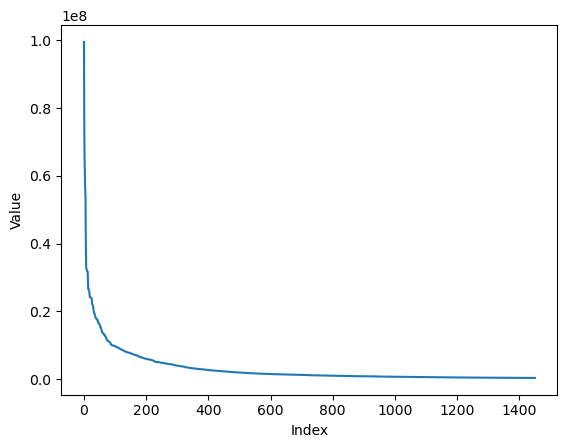

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
values = director_stats_sorted['total_popularity'].values

plt.plot(values[:int((len(director_stats_sorted)*0.05))])
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

In [18]:
from Artist_Director_Graph.actor_director_functions import visualize_actor_director_graph_500_nodes

visualize_actor_director_graph_500_nodes(actors_director_graph)

Here we performed community detection with the Louvain-algorithm.

Louvain detected 31 communities
The modularity: 0.4131


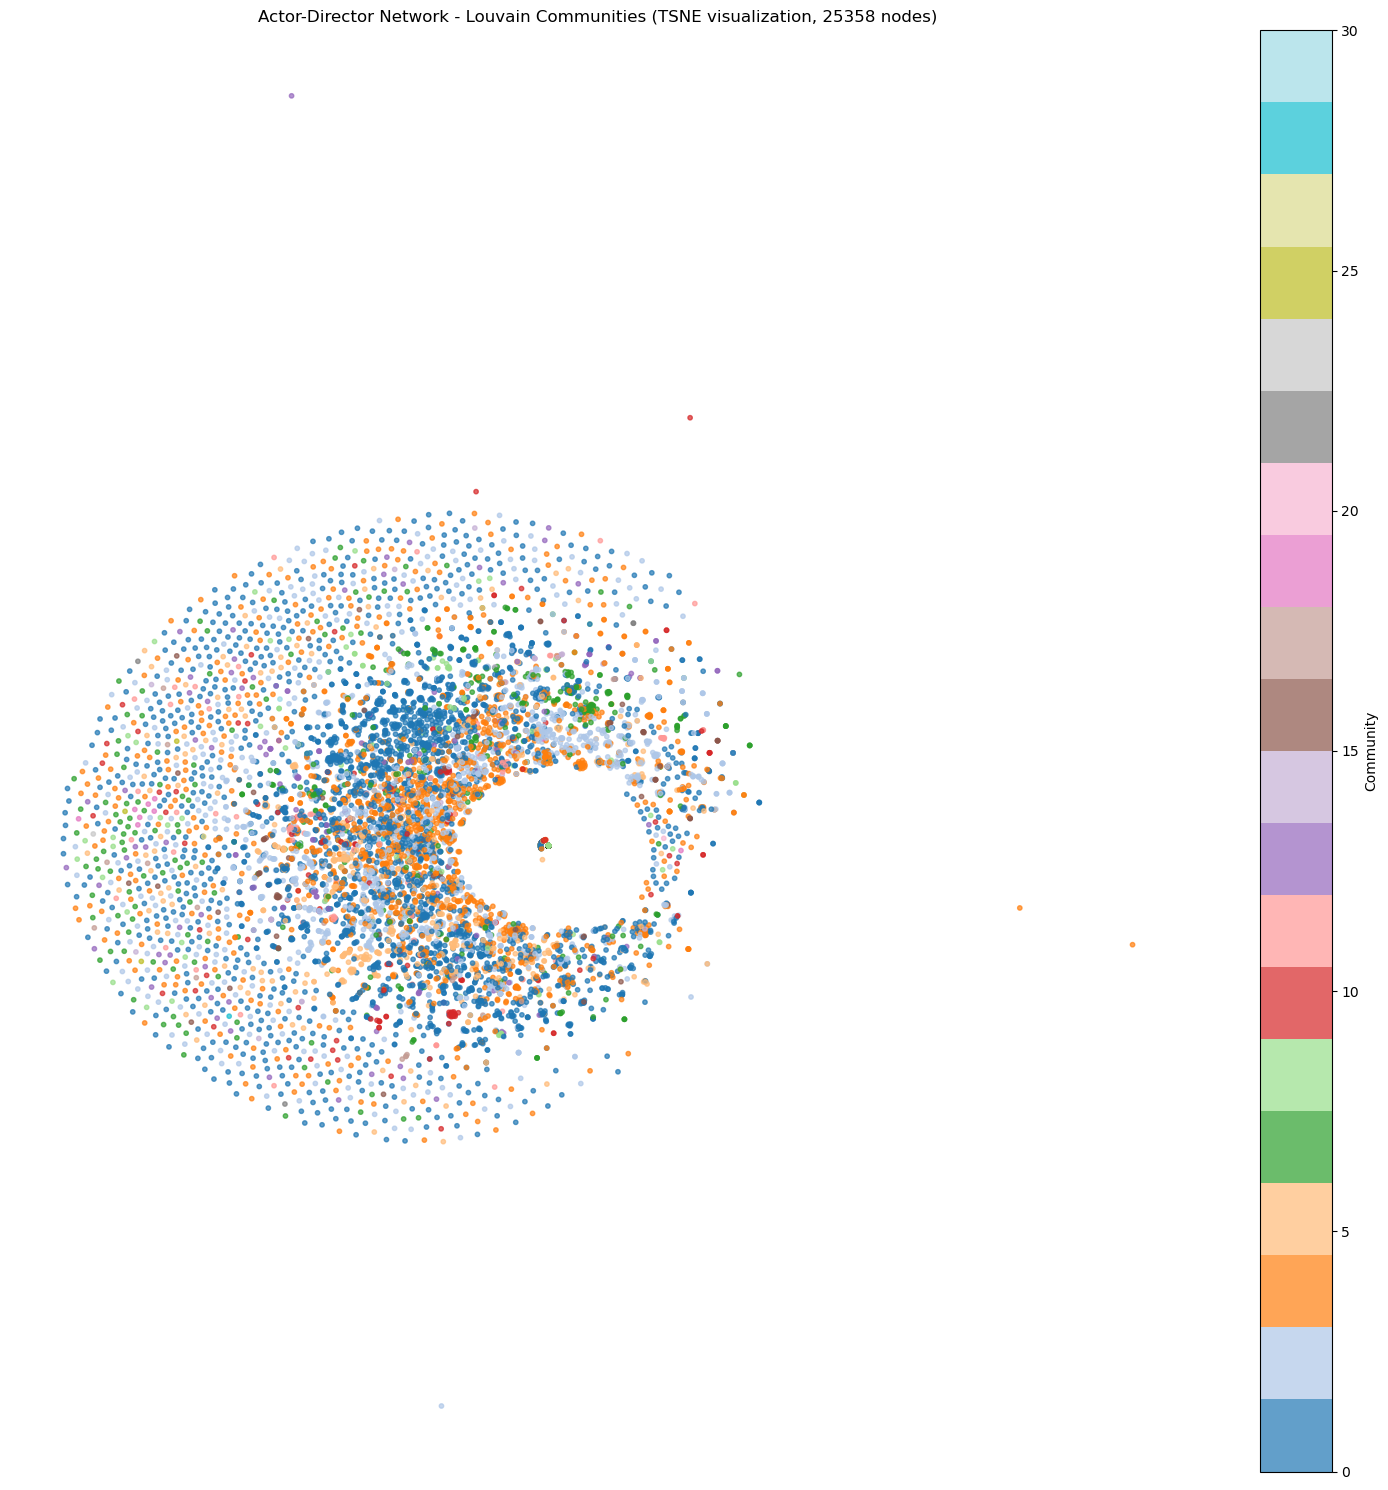

Number of communities detected: 31

Community sizes:
  Community 0: 5509 members
  Community 1: 3648 members
  Community 2: 3404 members
  Community 3: 3067 members
  Community 4: 2458 members
  Community 5: 1503 members
  Community 6: 1072 members
  Community 7: 860 members
  Community 8: 841 members
  Community 9: 681 members


In [19]:

from Artist_Director_Graph.actor_director_functions import calculate_partition, \
    visualize_louvain_communities, make_louvain_communities
import numpy as np
import networkx as nx

cluster_labels,nodes, embeddings = make_louvain_communities(actors_director_graph, actors_director_graph)

Here we print some of the members from each community.

In [20]:
from Artist_Director_Graph.actor_director_functions import clusters_to_node, print_members_for_each_clusters

# Create a dictionary mapping cluster to nodes
cluster_to_nodes = clusters_to_node(nodes, cluster_labels)
# Print members of each cluster
print_members_for_each_clusters(cluster_to_nodes)


Cluster 0 (5509 members):
Steve Guttenberg, Luke Kirby, Shanna Moakler, Kate Katzman, Kelly Brook, David Moscow, Oliver Reed, Robert Wagner, Jesse Ventura, Gabrielle Carteris
... and 5499 more

Cluster 1 (3648 members):
Susan Wokoma, Owen Teale, Elizabeth Rider, T'Nia Miller, Hugh Dancy, Joe Dempsie, Conleth Hill, Amber Anderson, Dan Futterman, Johnny Vegas
... and 3638 more

Cluster 2 (3404 members):
Jimmy Tatro, Elizabeth Bowen, David Koechner, Jeannie Berlin, Roan Curtis, Noah James, Jeremy Bobb, Joe Lo Truglio, Billy Crudup, Ashlie Atkinson
... and 3394 more

Cluster 3 (3067 members):
Scott Frank, Bob Balaban, Ralph Macchio, Judd Lormand, Scott Cooper, Oksana Lada, Peter Gallagher, Robert Prosky, Casey Siemaszko, Steve Zahn
... and 3057 more

Cluster 4 (2458 members):
Wagner Moura, Anna Nicole Smith, Xavier Dolan, Diogo Morgado, Gerard Depardieu, Jaime Camil, Gaia Weiss, Ernest Borgnine, Kasia Smutniak, Vanessa Paradis
... and 2448 more

Cluster 5 (1503 members):
Elliot Fletcher, 

We can see that the nodes with the biggest degree centrality are all established directors.

In [21]:
# Get degree centrality for filtered graph
degree_centrality = nx.degree_centrality(actors_director_graph)
sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True)[:10]

[('Woody Allen', 0.01372402098039989),
 ('Steven Spielberg', 0.012619789407264267),
 ('Clint Eastwood', 0.010805694679970028),
 ('Steven Soderbergh', 0.010687384154276926),
 ('Michael Bay', 0.009780336790629807),
 ('Ridley Scott', 0.009701463106834405),
 ('Oliver Stone', 0.009307094687857396),
 ('Ron Howard', 0.00855779469180108),
 ('James Franco', 0.008281736798517176),
 ('Eric Roberts', 0.008281736798517176)]

For each cluster whe print out the members who have the highest node centrality.

In [22]:
from Artist_Director_Graph.actor_director_functions import find_top_n_members_of_each_cluster

# Find top n members by centrality in each cluster
find_top_n_members_of_each_cluster(5, cluster_to_nodes,degree_centrality, actors_director_graph )


Cluster 0 - Top 5 most connected:
  Eric Roberts (degree: 210)
  Steven Brill (degree: 185)
  Danny Trejo (degree: 175)
  Dennis Dugan (degree: 158)
  Richard Riehle (degree: 154)

Cluster 1 - Top 5 most connected:
  Woody Allen (degree: 348)
  Steven Spielberg (degree: 320)
  Ridley Scott (degree: 246)
  Chris Columbus (degree: 190)
  Tim Burton (degree: 179)

Cluster 2 - Top 5 most connected:
  Shawn Levy (degree: 176)
  Jay Roach (degree: 174)
  Kevin Smith (degree: 157)
  Ben Stiller (degree: 155)
  Ivan Reitman (degree: 131)

Cluster 3 - Top 5 most connected:
  Clint Eastwood (degree: 274)
  Steven Soderbergh (degree: 271)
  Oliver Stone (degree: 236)
  Ron Howard (degree: 217)
  Brett Ratner (degree: 208)

Cluster 4 - Top 5 most connected:
  Joel Coen (degree: 172)
  Ethan Coen (degree: 172)
  Wes Craven (degree: 162)
  Gus Van Sant (degree: 144)
  Gerard Depardieu (degree: 118)

Cluster 5 - Top 5 most connected:
  Michael Bay (degree: 248)
  Roland Emmerich (degree: 200)
  Garr

Now we analyze which cluster contains directors with the highest node centrality.

In [23]:
from Artist_Director_Graph.actor_director_functions import calculate_member_centralities, \
    find_cluster_with_highest_avg_centrality

cluster_centralities = calculate_member_centralities(cluster_to_nodes, degree_centrality)

sorted_by_average_centrality = sorted( cluster_centralities.items(), key=lambda x: x[1]['avg_centrality'], reverse=True)

for rank, (cluster_id, data) in enumerate(sorted_by_average_centrality[:10], 1):
    print(f"\n{rank}. Cluster {cluster_id}:")
    print(f"   Avg centrality: {data['avg_centrality']:.6f}")
    print(f"   Size: {data['size']} members")


members_with_centrality = find_cluster_with_highest_avg_centrality(sorted_by_average_centrality, degree_centrality, actors_director_graph)




1. Cluster 3:
   Avg centrality: 0.000778
   Size: 3067 members

2. Cluster 5:
   Avg centrality: 0.000546
   Size: 1503 members

3. Cluster 2:
   Avg centrality: 0.000544
   Size: 3404 members

4. Cluster 1:
   Avg centrality: 0.000524
   Size: 3648 members

5. Cluster 0:
   Avg centrality: 0.000457
   Size: 5509 members

6. Cluster 11:
   Avg centrality: 0.000449
   Size: 333 members

7. Cluster 15:
   Avg centrality: 0.000421
   Size: 252 members

8. Cluster 6:
   Avg centrality: 0.000400
   Size: 1072 members

9. Cluster 10:
   Avg centrality: 0.000383
   Size: 445 members

10. Cluster 4:
   Avg centrality: 0.000299
   Size: 2458 members

Cluster 3 has the highest average centrality of 0.000778
Rank   Director or Actor                        Centrality      Degree    
1      Clint Eastwood                           0.010806        274       
2      Steven Soderbergh                        0.010687        271       
3      Oliver Stone                             0.009307        23

In [24]:
from Artist_Director_Graph.actor_director_functions import visualize_actor_director_graph

visualize_actor_director_graph(embeddings,cluster_labels, nodes )

We can also find people in the clusters with this function

In [25]:
from Artist_Director_Graph.actor_director_functions import find_person_cluster

# Find which cluster contains specific actors/directors

# Example usage
find_person_cluster("Lionel Barrymore", nodes, cluster_labels, cluster_to_nodes)
find_person_cluster("Tom Hanks", nodes, cluster_labels, cluster_to_nodes)

Lionel Barrymore not found (might have been filtered out)
Tom Hanks is in Cluster 5
Other members include: Elliot Fletcher, Lea DeLaria, James Mathers, Mickey Rooney, Gates McFadden...


In [26]:
director_popularity = director_stats_sorted

First we wanted to select the first few percentage of the directors as the "most popular directors". We made a cutoff for popular director at 400 as we discussed above.

In [81]:
from Artist_Director_Graph.actor_director_functions import calculate_popular_directors_for_each_cluster, print_popular_directors_in_each_cluster

# We find the most popular directors
n_popular = 400
popularity_threshold = director_popularity['total_popularity'].nlargest(n_popular).min()  #.quantile(0.75)
popular_directors = set(director_popularity[director_popularity['total_popularity'] >= popularity_threshold]['director'])


print(f"We select the first {len(popular_directors)} directors as popular directors. \n")

# Count popular directors in each cluster
cluster_popular_counts, cluster_popular_directors = calculate_popular_directors_for_each_cluster(cluster_to_nodes,popular_directors)

cluster_popular_directors_percentages= print_popular_directors_in_each_cluster(cluster_popular_counts, cluster_popular_directors, cluster_to_nodes)

We select the first 400 directors as popular directors. 

Cluster 0: 20 popular directors out of 5509 total members (0.4%)
  Examples: Keenen Ivory Wayans, James Cameron, Renny Harlin, Richard Donner, Sylvester Stallone

Cluster 1: 92 popular directors out of 3648 total members (2.5%)
  Examples: George Lucas, Chad Stahelski, David Leitch, Luc Besson, Yorgos Lanthimos

Cluster 2: 71 popular directors out of 3404 total members (2.1%)
  Examples: Jason Reitman, Phil Lord, Jon M. Chu, Tom McCarthy, Tate Taylor

Cluster 3: 98 popular directors out of 3067 total members (3.2%)
  Examples: Scott Cooper, Jan de Bont, Christopher McQuarrie, Clint Eastwood, Nick Cassavetes

Cluster 4: 24 popular directors out of 2458 total members (1.0%)
  Examples: George Clooney, Wes Craven, Mathieu Kassovitz, Michael Haneke, Roberto Benigni

Cluster 5: 41 popular directors out of 1503 total members (2.7%)
  Examples: J.J. Abrams, Andrew Stanton, Michael Bay, Pete Docter, Garry Marshall

Cluster 6: 30 popular

In [85]:
cluster_popular_directors_percentages

{0: 0.3630422944273008,
 1: 2.5219298245614032,
 2: 2.0857814336075204,
 3: 3.1953048581675905,
 4: 0.9764035801464606,
 5: 2.7278775781769795,
 6: 2.798507462686567,
 7: 0.23255813953488372,
 8: 0.356718192627824,
 9: 0.14684287812041116,
 10: 0.8988764044943821,
 11: 1.5015015015015014,
 12: 0.0,
 13: 1.3289036544850499,
 14: 0.33333333333333337,
 15: 0.3968253968253968,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.0,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.0,
 24: 0.0,
 25: 0.0,
 26: 0.0,
 27: 0.0,
 28: 0.0,
 29: 0.0,
 30: 0.0}

In [28]:
from Artist_Director_Graph.actor_director_functions import check_how_many_popular_directors_in_the_graph

# Check how many popular directors are actually in the graph nodes
check_how_many_popular_directors_in_the_graph(director_popularity, nodes)


  Found in graph: 15337
  NOT found in graph: 13686

Popular directors IN the graph:
  - Christopher Nolan
  - Quentin Tarantino
  - Steven Spielberg
  - Peter Jackson
  - David Fincher
  - Martin Scorsese
  - Ridley Scott
  - Frank Darabont
  - Robert Zemeckis
  - Clint Eastwood

Popular directors NOT in the graph (name mismatch or filtered out):
  - Mike Thurmeier
  - Kar-Wai Wong
  - Jee-woon Kim
  - Ki-duk Kim
  - Andrew Lau
  - Damián Szifron
  - Amole Gupte
  - Sang-ho Yeon
  - Alper Caglar
  - Galder Gaztelu-Urrutia



In [29]:
from Artist_Director_Graph.actor_director_functions import list_actors_who_worked_with_popular_directors_in_cluster
# For each cluster, list actors who worked with popular directors
list_actors_who_worked_with_popular_directors_in_cluster(cluster_to_nodes, cluster_popular_directors, actors_director_graph)

Cluster 0 - 20 popular director(s)

Keenen Ivory Wayans:
  Worked with 53 actors in this cluster
  Top collaborators:
    - Marlon Wayans (4 films)
    - Lochlyn Munro (3 films)
    - Anna Faris (2 films)
    - Brittany Daniel (2 films)
    - Dave Sheridan (2 films)
    - Keenen Ivory Wayans (2 films)
    - Regina Hall (2 films)
    - Alex Borstein (1 film)
    - Andrew Divoff (1 film)
    - Anne Dudek (1 film)

James Cameron:
  Worked with 48 actors in this cluster
  Top collaborators:
    - Arnold Schwarzenegger (2 films)
    - Bill Paxton (2 films)
    - Jenette Goldstein (2 films)
    - Art Malik (1 film)
    - Bernard Fox (1 film)
    - Bernard Hill (1 film)
    - Billy Zane (1 film)
    - CCH Pounder (1 film)
    - Charlton Heston (1 film)
    - Danny Cooksey (1 film)

Renny Harlin:
  Worked with 134 actors in this cluster
  Top collaborators:
    - Renny Harlin (5 films)
    - Rex Linn (3 films)
    - Samuel L. Jackson (3 films)
    - Geena Davis (2 films)
    - Johnathon Schaec

We have a Celebrity dataset which sort the most popular actors with a popularity sort. We check which cluster contains popular actors and we take the mean popularity of the popular actors.

ENI TODO: Leírni a average actor popularity mellé, hogy ez hány actornak az átlaga

In [89]:
from Artist_Director_Graph.actor_director_functions import clusters_by_average_actors_popularity

# Load celebrity data
df_celebrity = pd.read_csv('../Datasets/Celebrity.csv', index_col=0)

actor_popularity_map, cluster_avg_popularity = clusters_by_average_actors_popularity(df_celebrity, cluster_to_nodes)

Clusters ranked by average actor popularity:
Cluster 19: 58.58
Cluster 16: 57.86
Cluster 29: 44.79
Cluster 14: 40.46
Cluster 15: 39.94
Cluster 6: 39.87
Cluster 7: 38.76
Cluster 11: 38.15
Cluster 1: 37.87
Cluster 3: 37.75
Cluster 2: 37.36
Cluster 4: 37.21
Cluster 13: 35.97
Cluster 5: 35.37
Cluster 10: 33.43
Cluster 0: 32.95
Cluster 9: 32.23
Cluster 24: 31.95
Cluster 12: 30.93
Cluster 8: 30.55
Cluster 17: 29.44


Here we list the clusters with the highest degree centrality, the clusters where the percentage of directors who are popular are the higest, and the clusters where the average popularity of popular directors in the cluster are the highest. We can see that the clusters with the highest node centrality and, clusters with the highest director popularity percentage are really overlapping. This is not the case with the average popularity in the cluster, but this is also due to the fact that the average popularity of directors are not spread out that much, ranging only from approximately 30 to 59 from the lowest to the highest.

In [104]:
from Artist_Director_Graph.actor_director_functions import show_clusters_centrality_vs_popularity_table

show_clusters_centrality_vs_popularity_table([lst[0] for lst in sorted_by_average_centrality],sorted(cluster_popular_directors_percentages, key=cluster_popular_directors_percentages.get, reverse=True),sorted(cluster_avg_popularity, key=cluster_avg_popularity.get, reverse=True), 10 )

Degree centrality         Popular clusters     Average popularity clusters
--------------------------------------------------------------------------------
Cluster 3*                    Cluster 3*          Cluster 19                    
Cluster 5*                    Cluster 6*          Cluster 16                    
Cluster 2*                    Cluster 5*          Cluster 29                    
Cluster 1*                    Cluster 1*          Cluster 14                    
Cluster 0                     Cluster 2*          Cluster 15*                   
Cluster 11*                    Cluster 11*          Cluster 6*                   
Cluster 15*                    Cluster 13           Cluster 7                    
Cluster 6*                    Cluster 4*          Cluster 11*                   
Cluster 10*                    Cluster 10*          Cluster 1*                   
Cluster 4*                    Cluster 15*          Cluster 3*                   


In [31]:
actor_popularity_map['Gary Oldman']

212.888

In [32]:
df_celebrity

name        original_name  popularity  gender       id  \
0             Gary Oldman          Gary Oldman     212.888       2       64   
1           Ryan Reynolds        Ryan Reynolds     199.717       2    10859   
2          Sydney Sweeney       Sydney Sweeney     193.376       1   115440   
3           Jason Statham        Jason Statham     187.787       2      976   
4           Chloe Coleman        Chloe Coleman     175.645       1  1696016   
...                   ...                  ...         ...     ...      ...   
9975          Roan Curtis          Roan Curtis      21.938       1  1677354   
9976       Mirei Kiritani       Mirei Kiritani      21.938       1   230120   
9977       Dimple Kapadia       Dimple Kapadia      21.938       1    78921   
9978  Grażyna Szapołowska  Grażyna Szapołowska      21.938       1     1384   
9979     Ferdinando Poggi     Ferdinando Poggi      21.937       2   114645   

     known_for_department  adult  
0                  Acting  False  
1                  Acting  False  
2                  Acting  False  
3                  Acting  False  
4                  Acting  False  
...                   ...    ...  
9975               Acting  False  
9976               Acting  False  
9977               Acting  False  
9978               Acting  False  
9979               Acting  False  

[9980 rows x 7 columns]

In [33]:
from Artist_Director_Graph.actor_director_functions import map_nodes_to_cluster, calculate_edges_between_clusters, \
    calculate_between_cluster_connections

# Create a mapping of node to cluster
node_to_cluster = map_nodes_to_cluster(cluster_to_nodes)

# Count edges between clusters
n_clusters, inter_cluster_edges = calculate_edges_between_clusters(cluster_to_nodes, actors_director_graph, node_to_cluster)

# Show inter-cluster connections
calculate_between_cluster_connections(n_clusters, inter_cluster_edges, cluster_to_nodes)

Inter-cluster connections (edges between clusters):

Top 15 inter-cluster connections:
1. Cluster 3 -> Cluster 0: 4471 edges
2. Cluster 0 -> Cluster 3: 4443 edges
3. Cluster 3 -> Cluster 2: 3850 edges
4. Cluster 2 -> Cluster 3: 3729 edges
5. Cluster 3 -> Cluster 1: 3041 edges
6. Cluster 1 -> Cluster 3: 2551 edges
7. Cluster 0 -> Cluster 2: 2537 edges
8. Cluster 2 -> Cluster 0: 2497 edges
9. Cluster 5 -> Cluster 0: 1819 edges
10. Cluster 0 -> Cluster 1: 1717 edges
11. Cluster 0 -> Cluster 5: 1613 edges
12. Cluster 5 -> Cluster 3: 1565 edges
13. Cluster 2 -> Cluster 1: 1553 edges
14. Cluster 3 -> Cluster 5: 1420 edges
15. Cluster 1 -> Cluster 2: 1390 edges
Summary by cluster:
Cluster 0: Internal=19121, Outgoing=12863, Incoming=12712
Cluster 1: Internal=15058, Outgoing=8109, Incoming=10271
Cluster 2: Internal=12458, Outgoing=10783, Incoming=11278
Cluster 3: Internal=14632, Outgoing=15583, Incoming=15656
Cluster 4: Internal=5440, Outgoing=4377, Incoming=3410
Cluster 5: Internal=4426, Outgo

In [34]:
from Artist_Director_Graph.actor_director_functions import clusters_by_incoming_edges

# Rank clusters by incoming edges
clusters_by_incoming_edges(cluster_to_nodes, inter_cluster_edges, n_clusters)

Clusters ranked by INCOMING edges (actors from other clusters working with directors in this cluster):
1. Cluster 3: 15656 incoming edges (3067 members)
2. Cluster 0: 12712 incoming edges (5509 members)
3. Cluster 2: 11278 incoming edges (3404 members)
4. Cluster 1: 10271 incoming edges (3648 members)
5. Cluster 5: 5935 incoming edges (1503 members)
6. Cluster 4: 3410 incoming edges (2458 members)
7. Cluster 6: 3107 incoming edges (1072 members)
8. Cluster 10: 1212 incoming edges (445 members)
9. Cluster 11: 1151 incoming edges (333 members)
10. Cluster 8: 680 incoming edges (841 members)
11. Cluster 15: 617 incoming edges (252 members)
12. Cluster 12: 587 incoming edges (309 members)
13. Cluster 13: 471 incoming edges (301 members)
14. Cluster 7: 387 incoming edges (860 members)
15. Cluster 14: 219 incoming edges (300 members)
16. Cluster 17: 187 incoming edges (100 members)
17. Cluster 16: 62 incoming edges (154 members)
18. Cluster 9: 55 incoming edges (681 members)
19. Cluster 19: 

We analyze how many actors were working with popular directors in the beginning, middle or ending of their careers

In [35]:
# Use the actor_director_analysis module
from Artist_Director_Graph.actor_director_analysis import ActorDirectorAnalyzer

# Initialize analyzer with existing data
analyzer = ActorDirectorAnalyzer(
    cluster_to_nodes=cluster_to_nodes,
    name_lookup=name_lookup,
    min_films=5,
    min_career_length=5,
    popularity_percentile=0.75
)

# Note: The module expects different file paths, so we need to adjust
# Update the load_data method to use our existing dataframes
def load_data_from_existing(self):
    return df_celebrity, df_actors, df_movie_directors

# Monkey patch the load_data method to use our existing data
analyzer.load_data = lambda: (df_celebrity, df_actors, df_movie_directors, cluster_popular_directors)

# Run the analysis for cluster 4
results = analyzer.analyze_all_actors(cluster_id=16)



In [36]:
# Print the detailed report
if results:
    analyzer.print_detailed_report(results)
else:
    print("No actors found matching the criteria.")

No actors found matching the criteria.


In [37]:
from Artist_Director_Graph.actor_director_functions import list_actors_in_cluster

# Example: List actors from cluster x (which has high average popularity)
actors_list = list_actors_in_cluster(cluster_to_nodes, actor_popularity_map, actors_after_1980, cluster_id=22, show_top_n=20)

Actors in cluster 22
Total members: 9
Actors identified: 3
Directors: 6

Top 3 Actors by Popularity:
 1. Hanna Rieber                             (Popularity: N/A)
 2. Niv Sultan                               (Popularity: N/A)
 3. Neta Riskin                              (Popularity: N/A)


Sentiment analysis on movie's descriptions.

In [38]:
word_scores = {}
with open("labMIT-1.0.txt", 'r', encoding='utf-8') as f:
            next(f)
            for line in f:
                parts = line.strip().split('\t')
                if len(parts) >= 3:
                    word = parts[0].lower()
                    happiness_score = float(parts[2])
                    word_scores[word] = happiness_score

In [39]:
import nltk

nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/dhanna/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/dhanna/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/dhanna/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/dhanna/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


True

In [40]:
cluster_to_nodes

{5: ['Elliot Fletcher',
  'Lea DeLaria',
  'James Mathers',
  'Mickey Rooney',
  'Gates McFadden',
  'Jenny Lewis',
  'Perry King',
  'Khamani Griffin',
  'Jonathan Taylor Thomas',
  'Kelly Ripa',
  'Yeardley Smith',
  'David DeLuise',
  'Jim Belushi',
  'Julia Louis-Dreyfus',
  'Sean Murray',
  'Maite Perroni',
  'Richard Erdman',
  'Ralph Bellamy',
  'Cybill Shepherd',
  'Amy Jo Johnson',
  'Grey Griffin',
  'Miki Ishikawa',
  'Nika Futterman',
  'John Williams',
  'Tim Conway',
  'Alison Arngrim',
  'Colton Haynes',
  'Rip Torn',
  'Richard Steven Horvitz',
  'Felix Silla',
  'Josh Dallas',
  'Jennifer Grey',
  'Jona Xiao',
  'Matthew Broderick',
  'Gilbert Gottfried',
  'Wendy Makkena',
  'Nicole Scherzinger',
  'Billy Porter',
  'Sarah Michelle Gellar',
  'Jesse McCartney',
  'G.W. Bailey',
  'Alex D. Linz',
  'Majel Barrett',
  'Daniel Henney',
  'William Morgan Sheppard',
  'Vera Miles',
  'Rebecca Wisocky',
  'Efrem Zimbalist Jr.',
  'Kellie Martin',
  'Kelly Marie Tran',
  'Da

## Movies in Each Cluster

Now let's iterate through each cluster and collect all the movies associated with directors in those clusters.

In [41]:
from Artist_Director_Graph.cluster_movies_analysis import (
    collect_cluster_movies,
    get_unique_movies_per_cluster,
    print_cluster_movies_summary,
    print_cluster_movies_detail,
)

# Collect all movies for each cluster
cluster_movies = collect_cluster_movies(
    cluster_to_nodes=cluster_to_nodes,
    df_actors=df_actors,
    movie_directors_dict=movie_directors_dict,
    name_lookup=name_lookup
)

# Get unique movies (not actor-movie pairs)
cluster_unique_movies = get_unique_movies_per_cluster(cluster_movies)

# Print summary
summary = print_cluster_movies_summary(cluster_unique_movies, cluster_to_nodes, top_clusters=20)

Building director-to-movies mapping...
Found movies for 17170 directors

  Cluster  0:  21039 actor-movie entries,  4461 unique films, 2403 directors
  Cluster  1:  14869 actor-movie entries,  2795 unique films, 1435 directors
  Cluster  2:  15987 actor-movie entries,  2107 unique films, 1318 directors
  Cluster  3:  19649 actor-movie entries,  2488 unique films, 1120 directors
  Cluster  4:   8265 actor-movie entries,  3028 unique films, 1724 directors
  Cluster  5:   6357 actor-movie entries,   797 unique films,  564 directors
  Cluster  6:   2904 actor-movie entries,   631 unique films,  429 directors
  Cluster  7:   2003 actor-movie entries,   765 unique films,  580 directors
  Cluster  8:   1779 actor-movie entries,   914 unique films,  602 directors
  Cluster  9:   1012 actor-movie entries,   724 unique films,  446 directors
  Cluster 10:   1392 actor-movie entries,   270 unique films,  229 directors
  Cluster 11:   1177 actor-movie entries,   174 unique films,  151 directors
  C

In [190]:

df_movies_imdb[df_movies_imdb.index == 'tt0120867']['genre'].values[0].split(', ')

['Comedy', 'Crime', 'Drama']

In [196]:
'''
from Artist_Director_Graph.sentiment_analysis import calculate_sentiment_labmit

sentiment_scores_of_clusters = {}
movies_sentiment ={}
sentiment_scores_of_genres_in_clusters = {}

for cluster in cluster_unique_movies:
    genre_count = {}
    cluster_sentiment_score = 0
    sentiment_scores_of_genres_in_clusters[cluster] = {}
    for movie in cluster_movies[cluster]:
        film_id = movie['film_id']
        description = str(df_movies_imdb[df_movies_imdb.index == film_id]['description'])
        movies_sentiment[movie['film_id']] ={}

        sentiment = calculate_sentiment_labmit(description, word_scores)['labmit_mean']
        matching_rows = df_movies_imdb[df_movies_imdb.index == film_id]
        if not matching_rows.empty:
            movies_sentiment[film_id]['genres'] = df_movies_imdb[df_movies_imdb.index == film_id]['genre'].values[0].split(', ')
            movies_sentiment[film_id]['sentiment'] = sentiment
        cluster_sentiment_score += sentiment


        if len(matching_rows) > 0:
            for i in range(len(movies_sentiment[film_id]['genres'])):
                genre = movies_sentiment[film_id]['genres'][i]
                if genre not in sentiment_scores_of_genres_in_clusters[cluster]:
                    sentiment_scores_of_genres_in_clusters[cluster][genre] = 0
                sentiment_scores_of_genres_in_clusters[cluster][genre]+= movies_sentiment[film_id]['sentiment']
                if not genre in genre_count:
                    genre_count[genre] = 0
                genre_count[genre] +=1
    for key in sentiment_scores_of_genres_in_clusters[cluster]:
        sentiment_scores_of_genres_in_clusters[cluster][key] /= genre_count[key]

    if len(cluster_movies[cluster]) != 0:
        sentiment_scores_of_clusters[cluster] = cluster_sentiment_score / len(cluster_movies[cluster])
    else:
        sentiment_scores_of_clusters[cluster] = 0

for key, value in sentiment_scores_of_clusters.items():
    print(f"The sentiment of cluster {key} is {value}.")
'''


The sentiment of cluster 0 is 5.484616307020666.
The sentiment of cluster 1 is 5.511205950204323.
The sentiment of cluster 2 is 5.531246575161963.
The sentiment of cluster 3 is 5.493830930502093.
The sentiment of cluster 4 is 5.534324991903258.
The sentiment of cluster 5 is 5.492370461290195.
The sentiment of cluster 6 is 5.513636914699883.
The sentiment of cluster 7 is 5.505666535855009.
The sentiment of cluster 8 is 5.482340708320457.
The sentiment of cluster 9 is 5.528406076438922.
The sentiment of cluster 10 is 5.490626621263421.
The sentiment of cluster 11 is 5.461745805030435.
The sentiment of cluster 12 is 5.526571998348532.
The sentiment of cluster 13 is 5.5111053914316415.
The sentiment of cluster 14 is 5.517052006272594.
The sentiment of cluster 15 is 5.518327102362772.
The sentiment of cluster 16 is 5.2853762511880715.
The sentiment of cluster 17 is 5.516344116402495.
The sentiment of cluster 18 is 5.571842779959058.
The sentiment of cluster 19 is 5.5618438900281015.
The sen

We save the sentiment scores into files, because calculating them takes nearly 15 minutes.

In [203]:
'''
import json
sentiment_scores_of_clusters= {int(k): v for k, v in sentiment_scores_of_clusters.items()}
with open("sentiment_scores_of_clusters.json", "w") as f:
    json.dump(sentiment_scores_of_clusters, f, indent=4)

sentiment_scores_of_genres_in_clusters= {int(k): v for k, v in sentiment_scores_of_genres_in_clusters.items()}
with open("sentiment_scores_of_genres_in_clusters.json", "w") as f:
    json.dump(sentiment_scores_of_genres_in_clusters, f, indent=4)

'''


In [204]:
import json
with open("sentiment_scores_of_clusters.json", "r") as f:
    sentiment_scores_of_clusters = json.load(f)

with open("sentiment_scores_of_genres_in_clusters.json", "r") as f:
    sentiment_scores_of_genres_in_clusters = json.load(f)

In [205]:
for key, value in sentiment_scores_of_clusters.items():
    print(f"The sentiment of cluster {key} is {value}.")

The sentiment of cluster 0 is 5.484616307020666.
The sentiment of cluster 1 is 5.511205950204323.
The sentiment of cluster 2 is 5.531246575161963.
The sentiment of cluster 3 is 5.493830930502093.
The sentiment of cluster 4 is 5.534324991903258.
The sentiment of cluster 5 is 5.492370461290195.
The sentiment of cluster 6 is 5.513636914699883.
The sentiment of cluster 7 is 5.505666535855009.
The sentiment of cluster 8 is 5.482340708320457.
The sentiment of cluster 9 is 5.528406076438922.
The sentiment of cluster 10 is 5.490626621263421.
The sentiment of cluster 11 is 5.461745805030435.
The sentiment of cluster 12 is 5.526571998348532.
The sentiment of cluster 13 is 5.5111053914316415.
The sentiment of cluster 14 is 5.517052006272594.
The sentiment of cluster 15 is 5.518327102362772.
The sentiment of cluster 16 is 5.2853762511880715.
The sentiment of cluster 17 is 5.516344116402495.
The sentiment of cluster 18 is 5.571842779959058.
The sentiment of cluster 19 is 5.5618438900281015.
The sen

In [206]:
import pandas as pd

# Convert your dict to a DataFrame
df = pd.DataFrame(sentiment_scores_of_genres_in_clusters).T

# Compute global baseline
global_baseline = df.stack().mean()

# Compute Δh = score – global baseline
delta_df = df - global_baseline

print("Global baseline:", global_baseline)
print(delta_df)


Global baseline: 5.491331218895017
      Action  Thriller    Comedy    Horror     Crime     Drama    Sci-Fi  \
0  -0.092024 -0.058232  0.047647 -0.053948 -0.109198 -0.010383 -0.048606   
1  -0.039891 -0.067178  0.047567 -0.048918 -0.072821  0.025959  0.014480   
2  -0.053883 -0.022292  0.043334 -0.046170 -0.032955  0.053928 -0.012630   
3  -0.088444 -0.049762  0.039284  0.013605 -0.070969  0.005062 -0.062292   
4  -0.046661 -0.055911  0.085466 -0.026264 -0.072164  0.046534  0.009114   
5  -0.033420 -0.089201 -0.006973  0.042937 -0.075057  0.027916 -0.039048   
6  -0.024313 -0.040099  0.063188 -0.076493 -0.054858  0.017723  0.021082   
7  -0.069455 -0.106573  0.039346  0.108741 -0.072118  0.003910 -0.140425   
8  -0.178115 -0.057213 -0.037676 -0.285378 -0.104723  0.013335 -0.029566   
9  -0.028799 -0.036814  0.074500  0.025919 -0.068494  0.033419  0.075440   
10 -0.004864 -0.051540  0.037608 -0.020138 -0.026049  0.010289 -0.031118   
11 -0.085606 -0.072252  0.025891 -0.045974 -0.196449 

In [229]:
from Artist_Director_Graph.actor_director_functions import calculate_sentiment_scores_of_genres_in_clusters_results

sentiment_scores_of_genres_in_clusters_results = calculate_sentiment_scores_of_genres_in_clusters_results(sentiment_scores_of_genres_in_clusters)


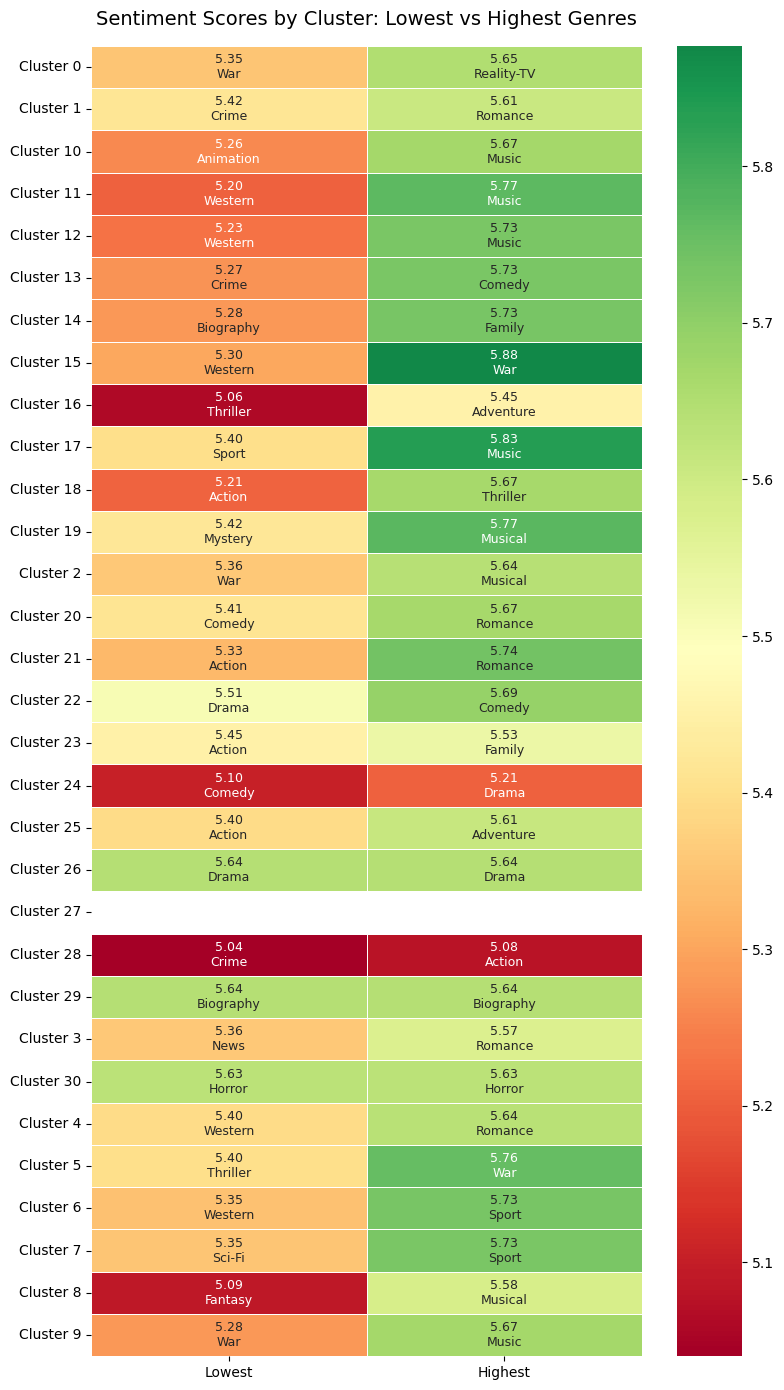

In [247]:
import seaborn as sns
rows = []
for cluster, values in sentiment_scores_of_genres_in_clusters_results.items():
    rows.append({
        'Cluster': cluster,
        'Genre': values['lowest_genre'],
        'Score': values['lowest_score'],
        'Type': 'Lowest'
    })
    rows.append({
        'Cluster': cluster,
        'Genre': values['highest_genre'],
        'Score': values['highest_score'],
        'Type': 'Highest'
    })

rows_df = pd.DataFrame(rows)

rows_df['Cluster_num'] = rows_df['Cluster']
rows_df= rows_df.sort_values('Cluster_num')
rows_df['Cluster'] = rows_df['Cluster'].apply(lambda x: f'Cluster {x}')


heatmap_data = rows_df.pivot(index='Cluster', columns='Type', values='Score')
heatmap_data = heatmap_data[['Lowest', 'Highest']]  # Order columns


genre_labels = rows_df.pivot(index='Cluster', columns='Type', values='Genre')
genre_labels = genre_labels[['Lowest', 'Highest']]

annot_labels = heatmap_data.copy().astype(str)
for idx in annot_labels.index:
    for col in annot_labels.columns:
        score = heatmap_data.loc[idx, col]
        genre = genre_labels.loc[idx, col]
        if pd.isna(score):
            annot_labels.loc[idx, col] = f'{genre}'
        else:
            annot_labels.loc[idx, col] = f'{score:.2f}\n{genre}'


fig, ax = plt.subplots(figsize=(8, 14))
sns.heatmap(heatmap_data, annot=annot_labels, fmt='', cmap='RdYlGn', center=df['Score'].mean(), ax=ax, annot_kws={'fontsize': 9}, linewidths=0.5, linecolor='white')

plt.title('Sentiment Scores by Cluster: Lowest vs Highest Genres', fontsize=14, pad=15)
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()
plt.savefig('sentiment_scores_by_clusters_by_genre.png', dpi=300, bbox_inches='tight')
plt.show()

In [44]:
from nltk import WordNetLemmatizer, word_tokenize, pos_tag
from Artist_Director_Graph.sentiment_analysis import get_wordnet_pos

text="You are beautiful."
lemmatizer = WordNetLemmatizer()
labmit_scores = []
lemmatized_docs = []
tokens = word_tokenize(text.lower())
pos_tags = pos_tag(tokens)
lemmatized = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]
lemmatized_docs.append(' '.join(lemmatized))

# Collect all scores
for token in tokens:
    if token in word_scores:
        score = word_scores[token]
        labmit_scores.append(score)

print(labmit_scores)

[6.24, 5.16, 7.92]


WWe did a sentiment analysis with a Hugging Face pipeline, using the "sentiment-analysis" model. (https://huggingface.co/blog/sentiment-analysis-python) This models runs for nearly one and a half hour so we saved the outcome to the llm_sentiment_scores_of_clusters.npy.

In [41]:
'''
from tqdm.auto import tqdm
from Artist_Director_Graph.sentiment_analysis import calculate_sentiment

llm_sentiment_scores_of_clusters = {}

for cluster in tqdm(cluster_unique_movies):
    # Collect all descriptions for this cluster
    descriptions = []
    for movie in cluster_movies[cluster]:
        description = str(df_movies_imdb[df_movies_imdb.index == movie['film_id']]['description'].values)
        if description and description != 'nan':
            descriptions.append(description)

    # Batch process all descriptions at once
    if descriptions:
        sentiment_results = calculate_sentiment(descriptions, batch_size=32)

        # Convert sentiment results to numerical scores (0-1 scale)
        # POSITIVE → score (0.5-1.0), NEGATIVE → 1-score (0.0-0.5)
        sentiment_scores = []
        for result in sentiment_results:
            if result:
                if result['label'] == 'POSITIVE':
                    sentiment_scores.append(result['score'])
                else:  # NEGATIVE
                    sentiment_scores.append(1 - result['score'])

        # Calculate average sentiment for the cluster
        if sentiment_scores:
            llm_sentiment_scores_of_clusters[cluster] = sum(sentiment_scores) / len(sentiment_scores)
        else:
            llm_sentiment_scores_of_clusters[cluster] = 0.5  # neutral default
    else:
        llm_sentiment_scores_of_clusters[cluster] = 0.5  # neutral default
'''

"\nfrom tqdm.auto import tqdm\nfrom Artist_Director_Graph.sentiment_analysis import calculate_sentiment\n\nllm_sentiment_scores_of_clusters = {}\n\nfor cluster in tqdm(cluster_unique_movies):\n    # Collect all descriptions for this cluster\n    descriptions = []\n    for movie in cluster_movies[cluster]:\n        description = str(df_movies_imdb[df_movies_imdb.index == movie['film_id']]['description'].values)\n        if description and description != 'nan':\n            descriptions.append(description)\n\n    # Batch process all descriptions at once\n    if descriptions:\n        sentiment_results = calculate_sentiment(descriptions, batch_size=32)\n\n        # Convert sentiment results to numerical scores (0-1 scale)\n        # POSITIVE → score (0.5-1.0), NEGATIVE → 1-score (0.0-0.5)\n        sentiment_scores = []\n        for result in sentiment_results:\n            if result:\n                if result['label'] == 'POSITIVE':\n                    sentiment_scores.append(result['sc

Here we load the precomputed llm sentiment scores from the of_clusters from the llm_sentiment_scores_of_clusters.npy file.

In [253]:
#np.save("llm_sentiment_scores_of_clusters", llm_sentiment_scores_of_clusters)
_llm_sentiment_scores_of_clusters = np.load("llm_sentiment_scores_of_clusters.npy", allow_pickle=True).item()
print(_llm_sentiment_scores_of_clusters)

{0: 0.49884087357409157, 1: 0.6256001282718563, 2: 0.0012641549110412598, 3: 0.5415876712787356, 4: 0.42303328770251314, 5: 0.5896448723985928, 6: 0.840635135769844, 7: 0.610425024712801, 8: 0.5329450638063492, 9: 0.6410132329743188, 10: 0.39829768737157184, 11: 0.5422851474760956, 12: 0.6575550651005484, 13: 0.16385726506016643, 14: 0.686577320098877, 15: 0.6322006583213806, 16: 0.6134870300690333, 17: 0.6334950675000001, 18: 0.5916924473563748, 19: 0.5826734955802735, 20: 0.6226212937088227, 21: 0.6317983905134885, 22: 0.583894481598587, 23: 0.704132382247759, 24: 0.6671978970053335, 25: 0.9631664355595907, 26: 0.9710230032602946, 27: 0.5427695678586071, 28: 0.9991794705390931}


This is the barchart of the sentiment of each clusters using Hugging Face's pipeline. A sentiment is if it is close to 1 and negative if it is close to 0.

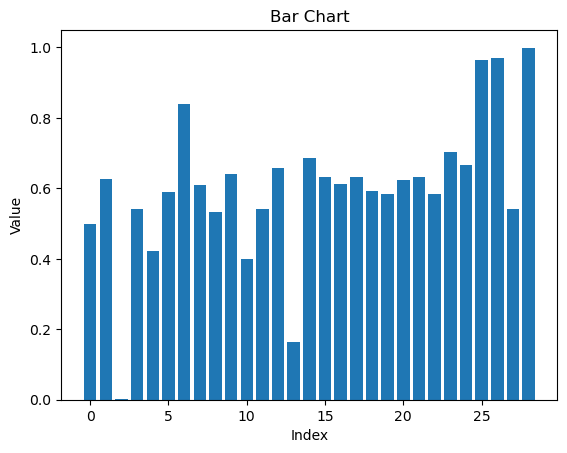

In [254]:
from matplotlib import pyplot as plt

# Extract keys and values from the dictionary
keys = list(_llm_sentiment_scores_of_clusters.keys())
values = list(_llm_sentiment_scores_of_clusters.values())

# Create the bar chart
plt.bar(keys, values)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Bar Chart')
plt.show()

ENI TODO: Put the Sentiment analysis scores on a scale from 0-100


## Analyze the clusters by genre and production companies
Genre distribution across different clusters.

In [49]:
from Artist_Director_Graph.cluster_attribute_analysis import (
    map_movies_to_attributes,
    analyze_attribute_distribution,
    get_specialization_score,
    compare_clusters_by_attribute,
    visualize_top_attributes_by_cluster,
    print_specialization_ranking,
    create_attribute_heatmap
)

# Map movies to genres
cluster_genres = map_movies_to_attributes(cluster_movies, df_movies_imdb, analysis_type='genre')

print(f"\nWe found genres for {len(cluster_genres)} clusters")


We found genres for 31 clusters


In [50]:
# Analyze genre distribution for each cluster
cluster_genre_stats = analyze_attribute_distribution(
    cluster_genres,
    cluster_to_nodes,
    analysis_type='genre',
    top_n=10
)

Genre analysis by cluster

Cluster 0 (5509 movies)
  Total movies which have genres information: 44227
  From this, there was  21 number of genres:
  Top 10 genres:
     1. Drama                                8235 ( 18.6%)
     2. Comedy                               7528 ( 17.0%)
     3. Action                               5493 ( 12.4%)
     4. Thriller                             4795 ( 10.8%)
     5. Crime                                3396 (  7.7%)
     6. Horror                               3277 (  7.4%)
     7. Romance                              2469 (  5.6%)
     8. Adventure                            1794 (  4.1%)
     9. Family                               1455 (  3.3%)
    10. Mystery                              1321 (  3.0%)

Cluster 1 (3648 movies)
  Total movies which have genres information: 34487
  From this, there was  20 number of genres:
  Top 10 genres:
     1. Drama                                9048 ( 26.2%)
     2. Comedy                               45

high diversity score means the cluster works across many genres, while a low score indicates specialization in fewer genres.

Visualizations to better understand the genre patterns across clusters.


Visualization saved as 'cluster_genre_distribution.png'


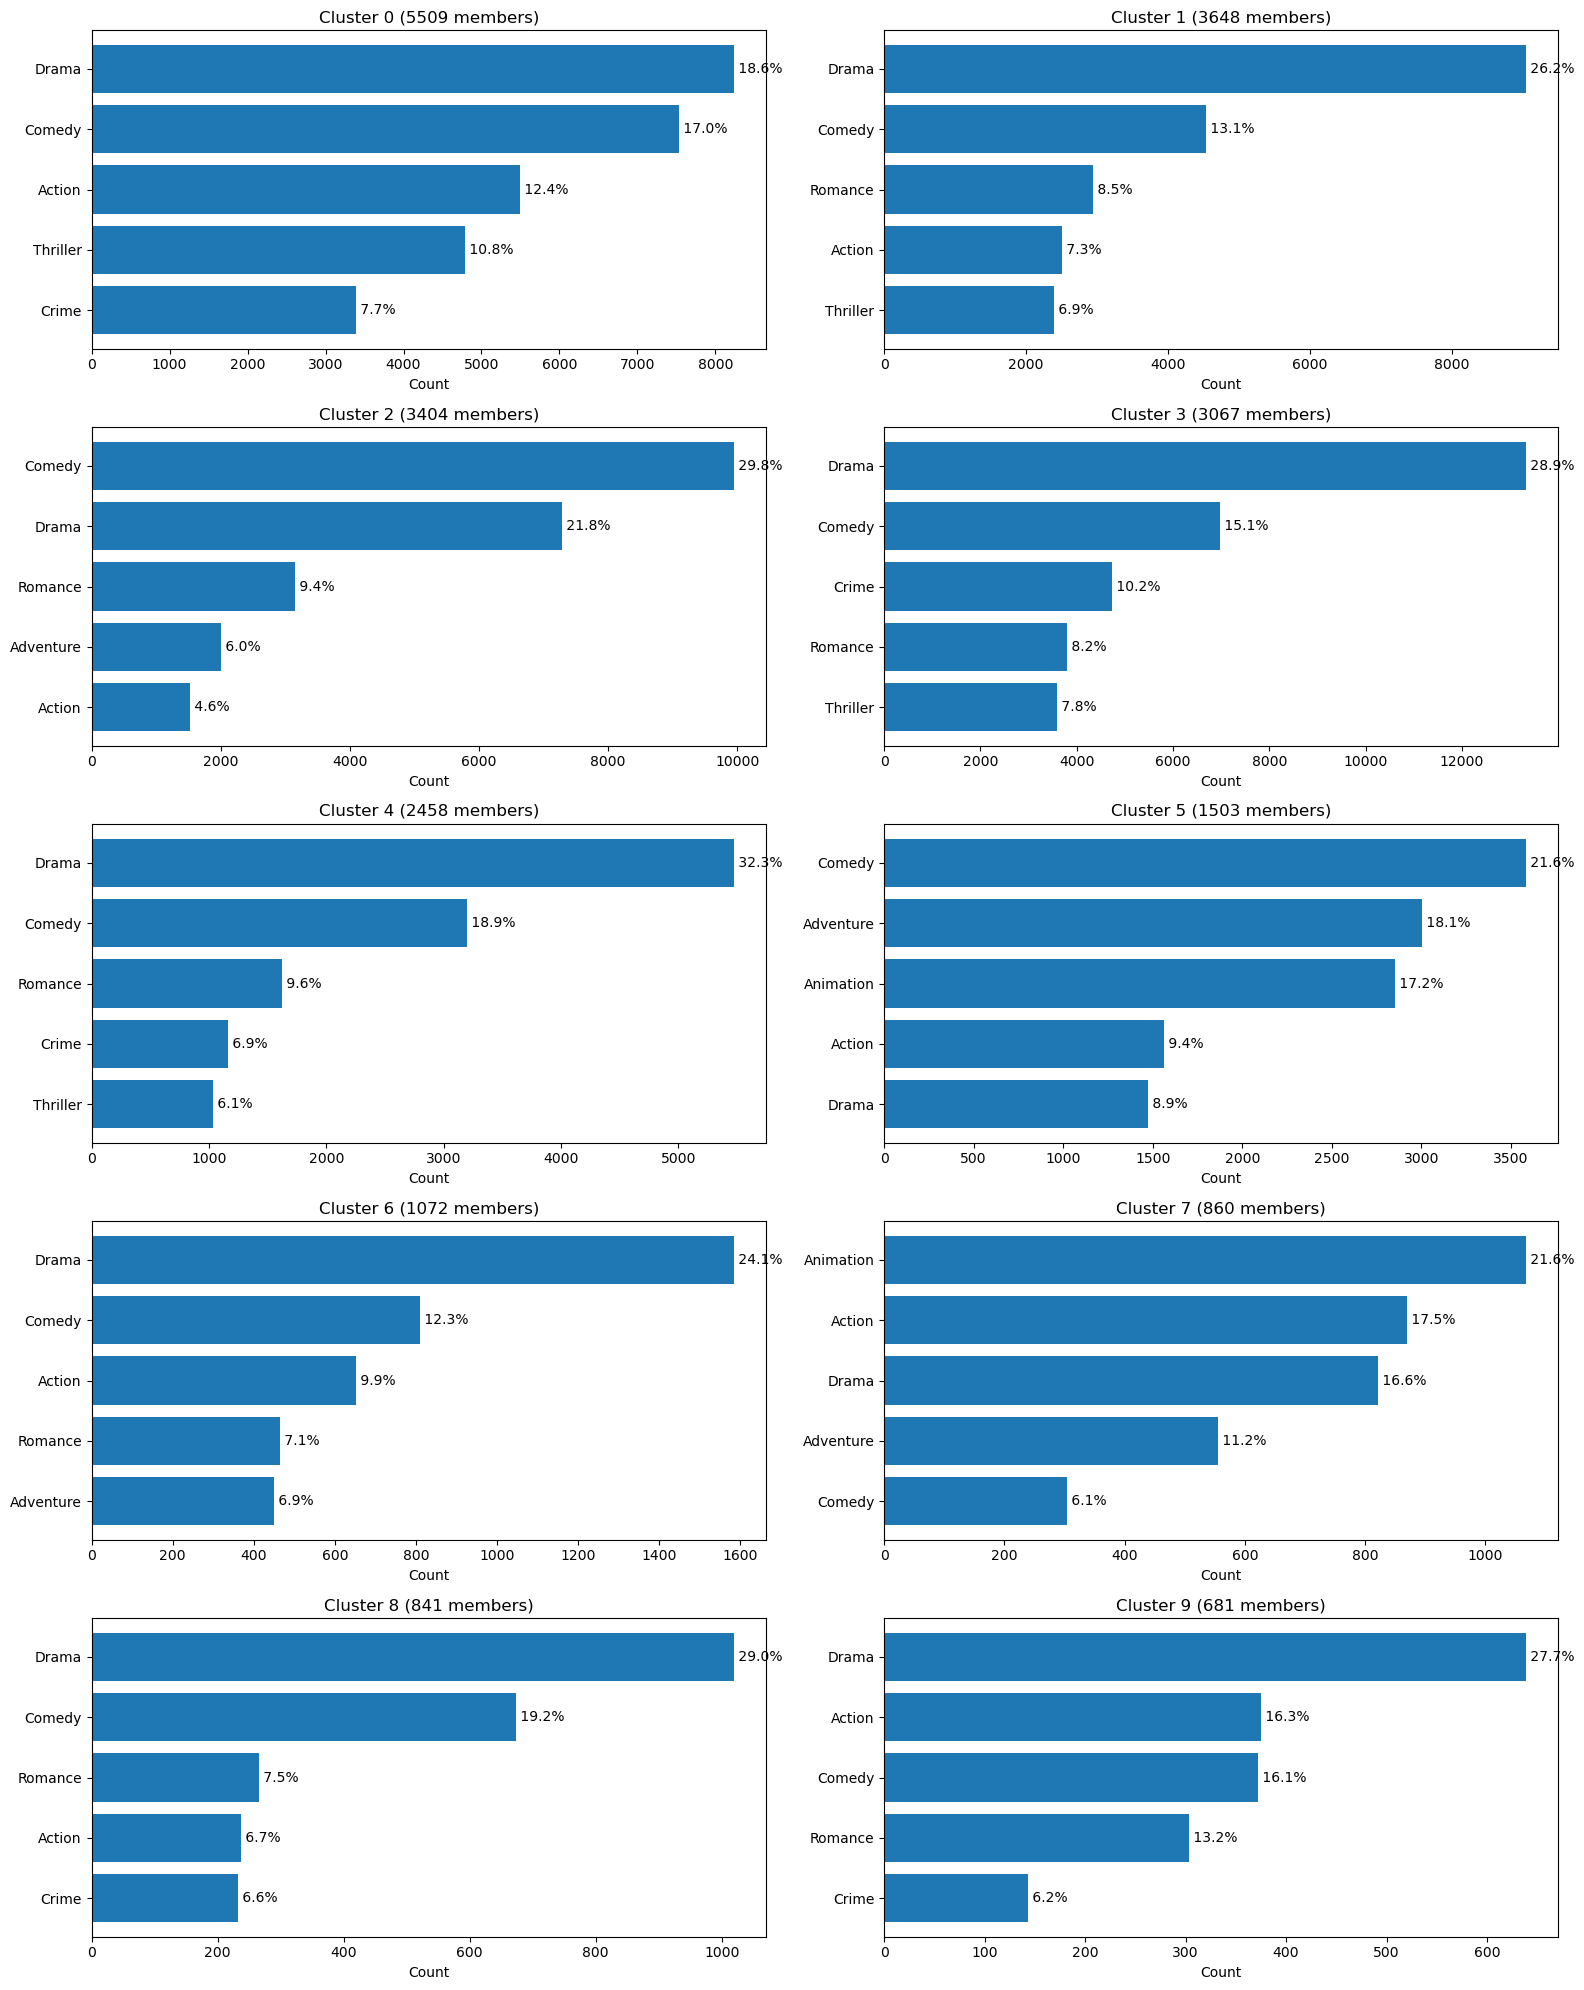

In [51]:
# Visualize top genres for the largest clusters
fig_genres = visualize_top_attributes_by_cluster(cluster_genre_stats, analysis_type='genre', top_clusters=len(cluster_movies), top_items=5)

Genre Specialization ranking

Most Specialized (focused on fewer genres):
 1. Cluster 26: Diversity=0.000, Unique=1, Total mentions=2
      → Top genres: Drama (100.0%)
 2. Cluster 29: Diversity=0.000, Unique=1, Total mentions=2
      → Top genres: Biography (100.0%)
 3. Cluster 30: Diversity=0.000, Unique=1, Total mentions=1
      → Top genres: Horror (100.0%)
 4. Cluster 16: Diversity=0.709, Unique=11, Total mentions=765
      → Top genres: Action (29.3%), Comedy (26.7%), Animation (23.0%)
 5. Cluster  9: Diversity=0.737, Unique=19, Total mentions=2304
      → Top genres: Drama (27.7%), Action (16.3%), Comedy (16.1%)
 6. Cluster  5: Diversity=0.752, Unique=20, Total mentions=16590
      → Top genres: Comedy (21.6%), Adventure (18.1%), Animation (17.2%)
 7. Cluster  4: Diversity=0.754, Unique=20, Total mentions=16916
      → Top genres: Drama (32.3%), Comedy (18.9%), Romance (9.6%)
 8. Cluster  2: Diversity=0.759, Unique=20, Total mentions=33381
      → Top genres: Comedy (29.8%), Dra

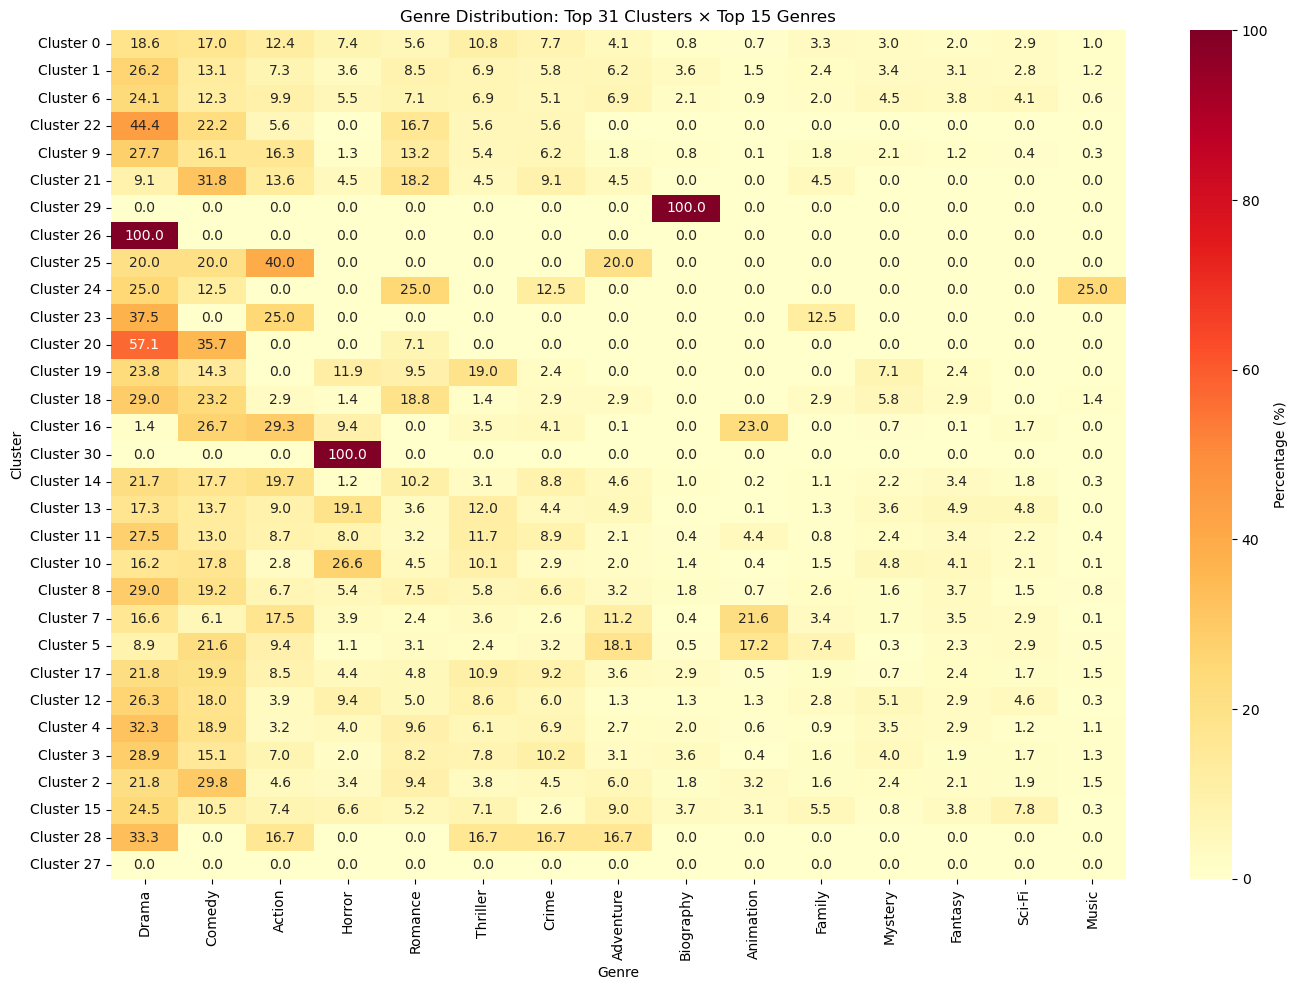

In [52]:
# Calculate genre specialization scores and create heatmap
genre_specialization_scores = get_specialization_score(cluster_genres)
print_specialization_ranking(genre_specialization_scores, cluster_genres, analysis_type='genre', show_top_n=3)

# Create genre comparison matrix and heatmap
genre_matrix = compare_clusters_by_attribute(cluster_genres)
df_genre_heatmap = create_attribute_heatmap(genre_matrix, analysis_type='genre', top_n_clusters=len(cluster_movies), top_n_items=15)

In [53]:
# Production Company Analysis
# Map movies to production companies
print("Mapping cluster movies to production companies...")
cluster_companies = map_movies_to_attributes(cluster_movies, df_movies_imdb, analysis_type='production_company')

print(f"\nMapped production companies for {len(cluster_companies)} clusters")

# Analyze production company distribution for each cluster
cluster_company_stats = analyze_attribute_distribution(
    cluster_companies,
    cluster_to_nodes,
    analysis_type='production_company',
    top_n=10
)

Mapping cluster movies to production companies...

Mapped production companies for 31 clusters
Production Company analysis by cluster

Cluster 0 (5509 movies)
  Total movies which have production companies information: 19510
  From this, there was  2800 number of production companies:
  Top 10 production companies:
     1. New Line Cinema                       294 (  1.5%)
     2. Dimension Films                       268 (  1.4%)
     3. Universal Pictures                    239 (  1.2%)
     4. Paramount Pictures                    239 (  1.2%)
     5. Columbia Pictures                     219 (  1.1%)
     6. Warner Bros.                          211 (  1.1%)
     7. Twentieth Century Fox                 178 (  0.9%)
     8. Walt Disney Pictures                  151 (  0.8%)
     9. Cinetel Films                         134 (  0.7%)
    10. PM Entertainment Group                129 (  0.7%)

Cluster 1 (3648 movies)
  Total movies which have production companies information: 14088
  

Visualizations to better understand the production company patterns across clusters.


Visualization saved as 'cluster_production_company_distribution.png'
Production Company Specialization ranking

Most Specialized (focused on fewer production companies):
 1. Cluster 23: Diversity=0.000, Unique=1, Total mentions=2
      → Top production companies: DLP Media (100.0%)
 2. Cluster 29: Diversity=0.000, Unique=1, Total mentions=2
      → Top production companies: Fulwell 73 (100.0%)
 3. Cluster 30: Diversity=0.000, Unique=1, Total mentions=1
      → Top production companies: William Winckler Productions (100.0%)
 4. Cluster 16: Diversity=0.497, Unique=21, Total mentions=273
      → Top production companies: A Bunch of Filmmakers (64.5%), Vestra Pictures (8.8%), Body Bag Films (8.1%)
 5. Cluster 15: Diversity=0.772, Unique=71, Total mentions=713
      → Top production companies: Elysium Bandini Studios (26.4%), Columbia Pictures (10.0%), RabbitBandini Productions (9.0%)
 6. Cluster 11: Diversity=0.805, Unique=148, Total mentions=1126
      → Top production companies: Dimensi

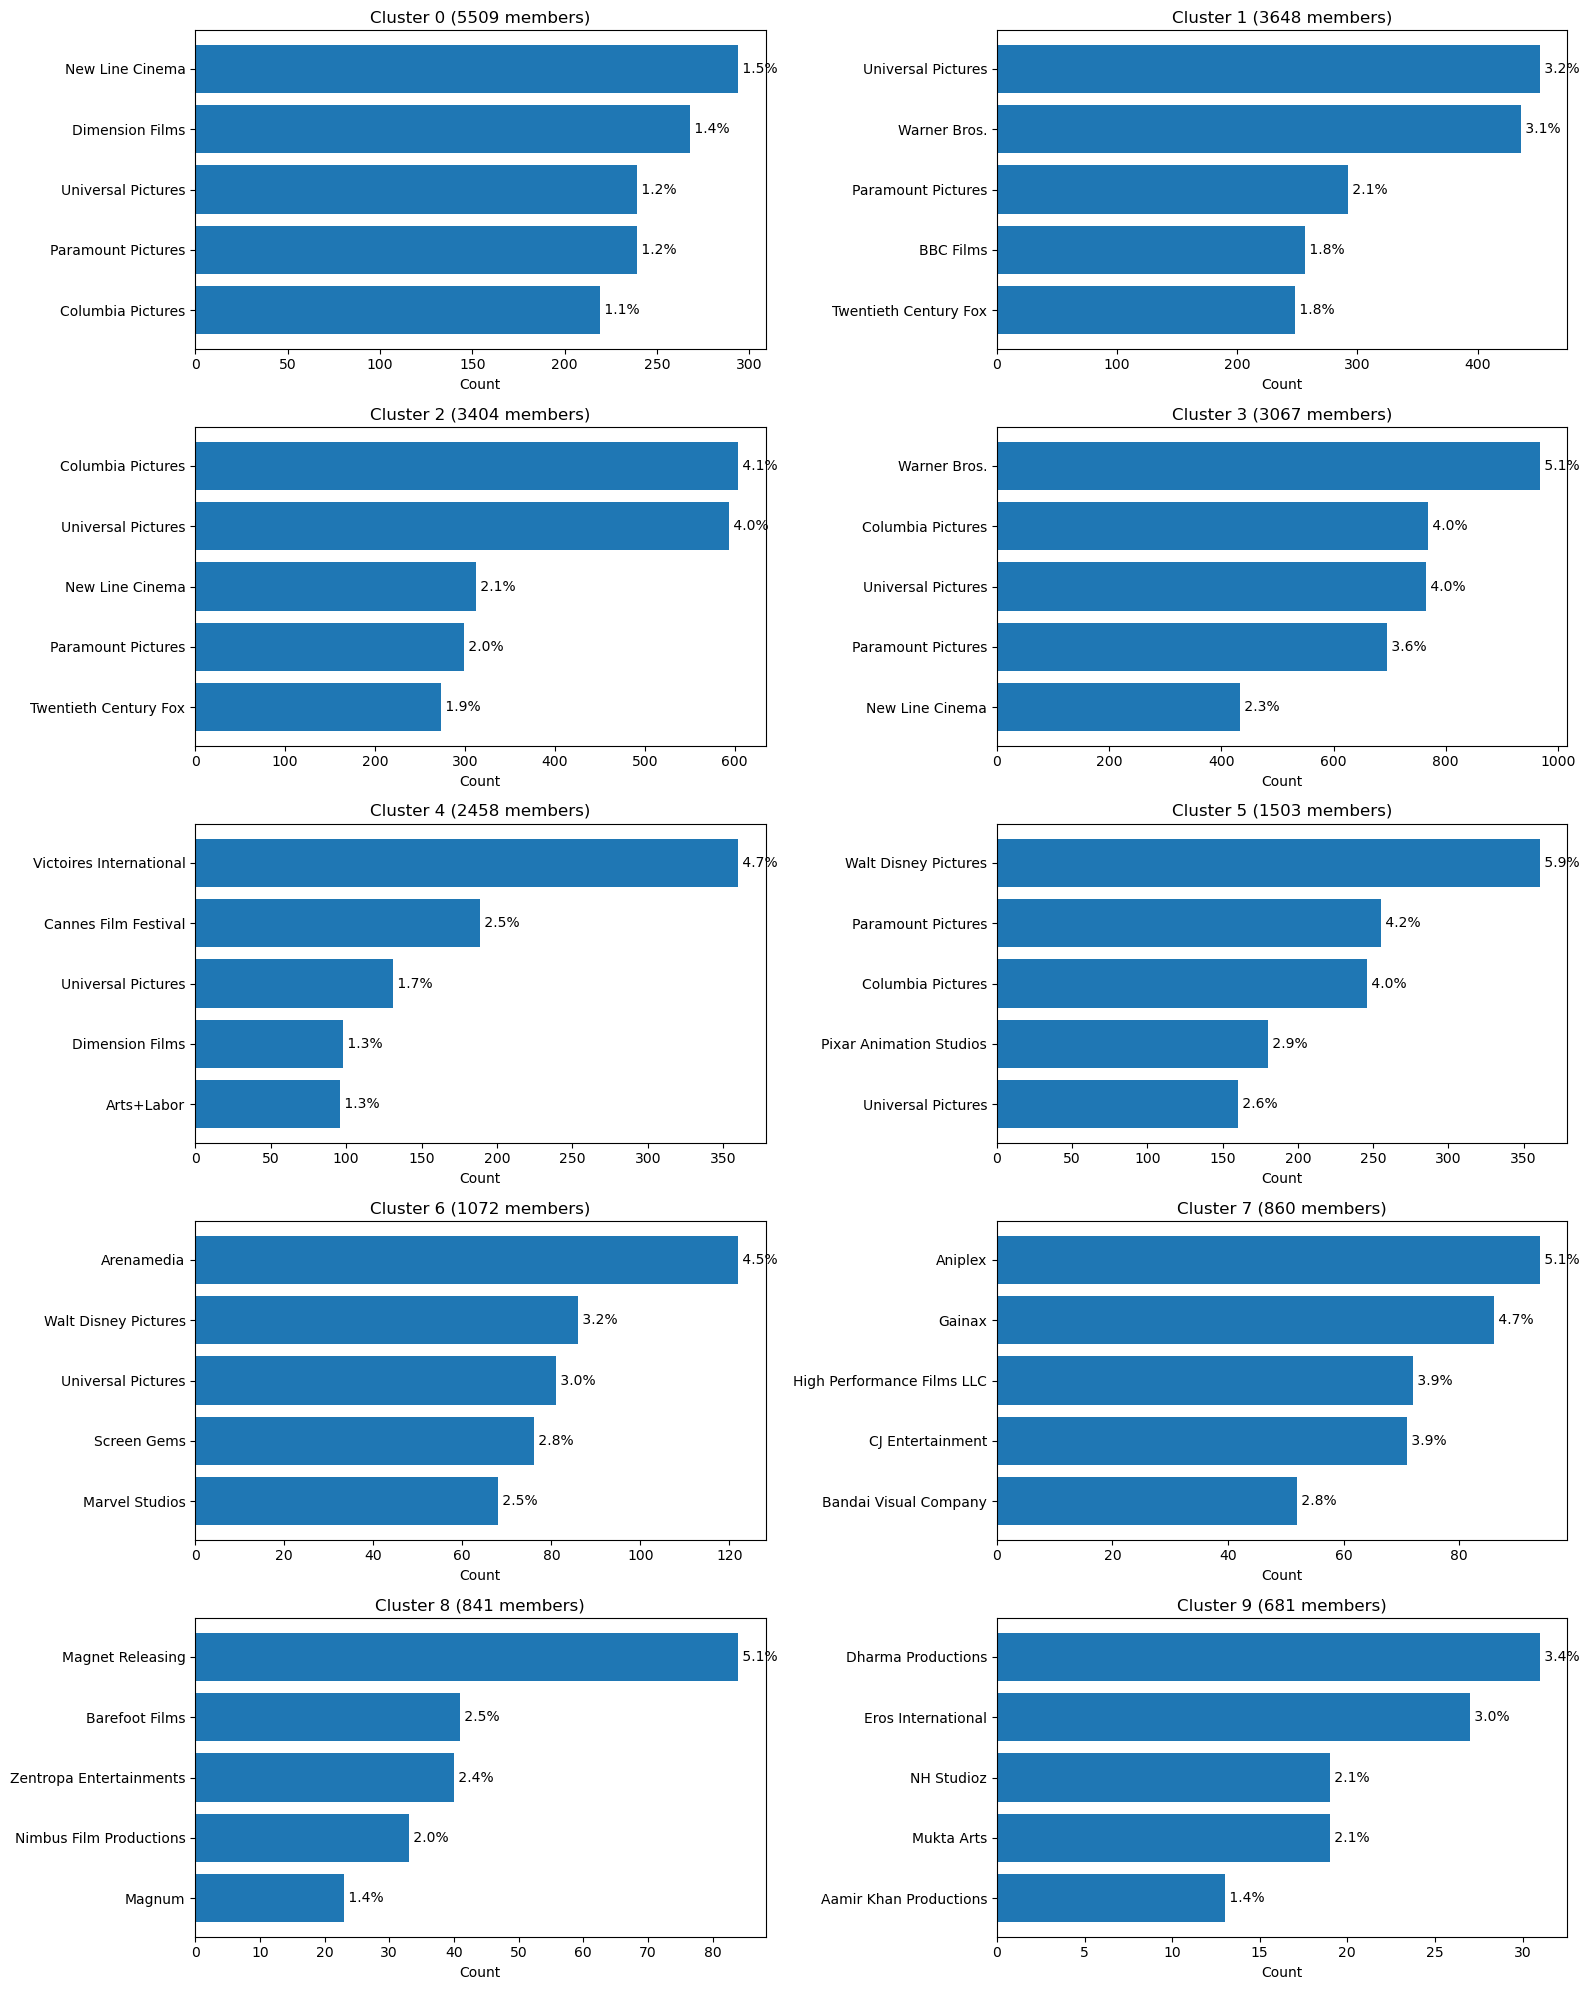

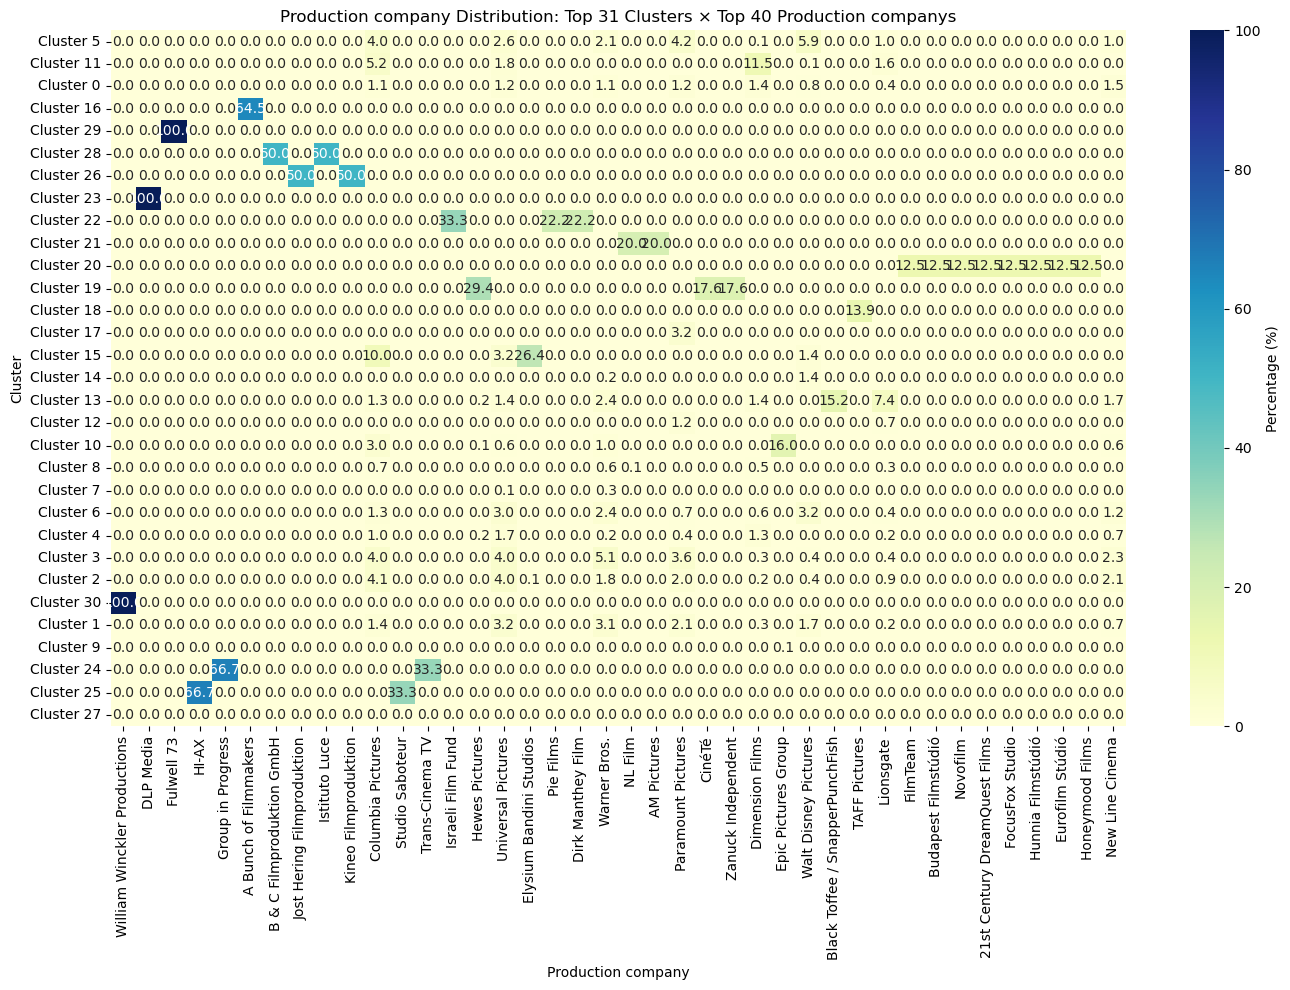

In [54]:
# Visualize top production companies for the largest clusters
fig_companies = visualize_top_attributes_by_cluster(cluster_company_stats, analysis_type='production_company', top_clusters=10, top_items=5)

# Calculate production company specialization scores and create heatmap
company_specialization_scores = get_specialization_score(cluster_companies)
print_specialization_ranking(company_specialization_scores, cluster_companies, analysis_type='production_company', show_top_n=3)

# Create production company comparison matrix and heatmap
company_matrix = compare_clusters_by_attribute(cluster_companies)
df_company_heatmap = create_attribute_heatmap(company_matrix, analysis_type='production_company', top_n_clusters=len(cluster_movies), top_n_items=40)

Time Era analysis

In [55]:
from Artist_Director_Graph.cluster_time_period_analysis import (
    analyze_cluster_time_periods,
    categorize_by_era,
    print_time_period_summary,
    find_era_specialized_clusters,
    visualize_era_distribution,
    create_timeline_heatmap
)

In [56]:
# Analyze time period statistics for each cluster
df_time_stats = analyze_cluster_time_periods(cluster_unique_movies, cluster_to_nodes)

# Categorize movies by era (Classic, Golden Age, Modern, Contemporary)
df_era = categorize_by_era(cluster_unique_movies, cluster_to_nodes)

In [57]:
# Print comprehensive time period summary
print_time_period_summary(df_time_stats, df_era, top_n=20)

TIme period analysis by cluster:

Cluster  Movies   Members  Year Range      Mean Year    Median   Dominant Era   
----------------------------------------------------------------------------------------------------
0        4461     5509     1990-2021       2006.8       2008     Modern         
4        3028     2458     1990-2021       2008.0       2009     Modern         
1        2795     3648     1990-2021       2008.1       2010     Modern         
3        2488     3067     1990-2021       2005.9       2006     Modern         
2        2107     3404     1990-2021       2012.3       2014     Modern         
8        914      841      1990-2021       2009.9       2011     Modern         
5        797      1503     1990-2021       2006.4       2007     Modern         
7        765      860      1990-2021       2010.3       2012     Modern         
9        724      681      1990-2021       2009.0       2010     Modern         
6        631      1072     1990-2021       2010.8      

In [58]:
# Find clusters that are specialized in specific eras (>60% of movies in one era)
specialized_clusters = find_era_specialized_clusters(df_era, threshold=60)


Clusters specialized in specific eras(>60% in one era)

Cluster    Era                            Movies          Percentage  
----------------------------------------------------------------------
25         Contemporary (2016-2021)       2/2          100.0       %
26         Contemporary (2016-2021)       3/3          100.0       %
29         Contemporary (2016-2021)       2/2          100.0       %
30         Golden Age (2000-2008)         1/1          100.0       %
24         Classic (pre-2000)             2/3          66.7        %



Visualization saved as 'cluster_era_distribution.png'


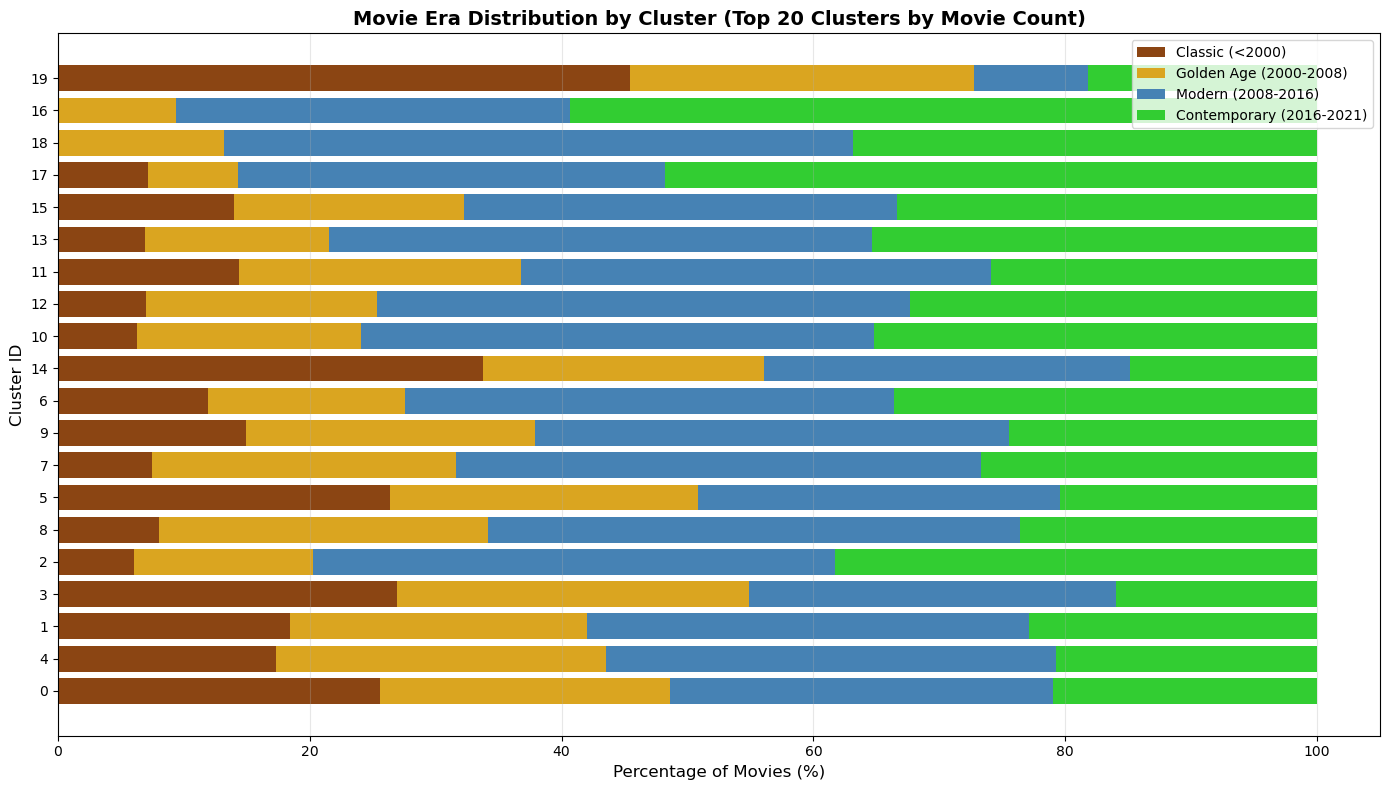

In [59]:
# Create era distribution visualization (stacked bar chart)
fig_era = visualize_era_distribution(df_era, output_file='cluster_era_distribution.png', top_n=20)

Timeline heatmap saved as 'cluster_timeline_heatmap.png'


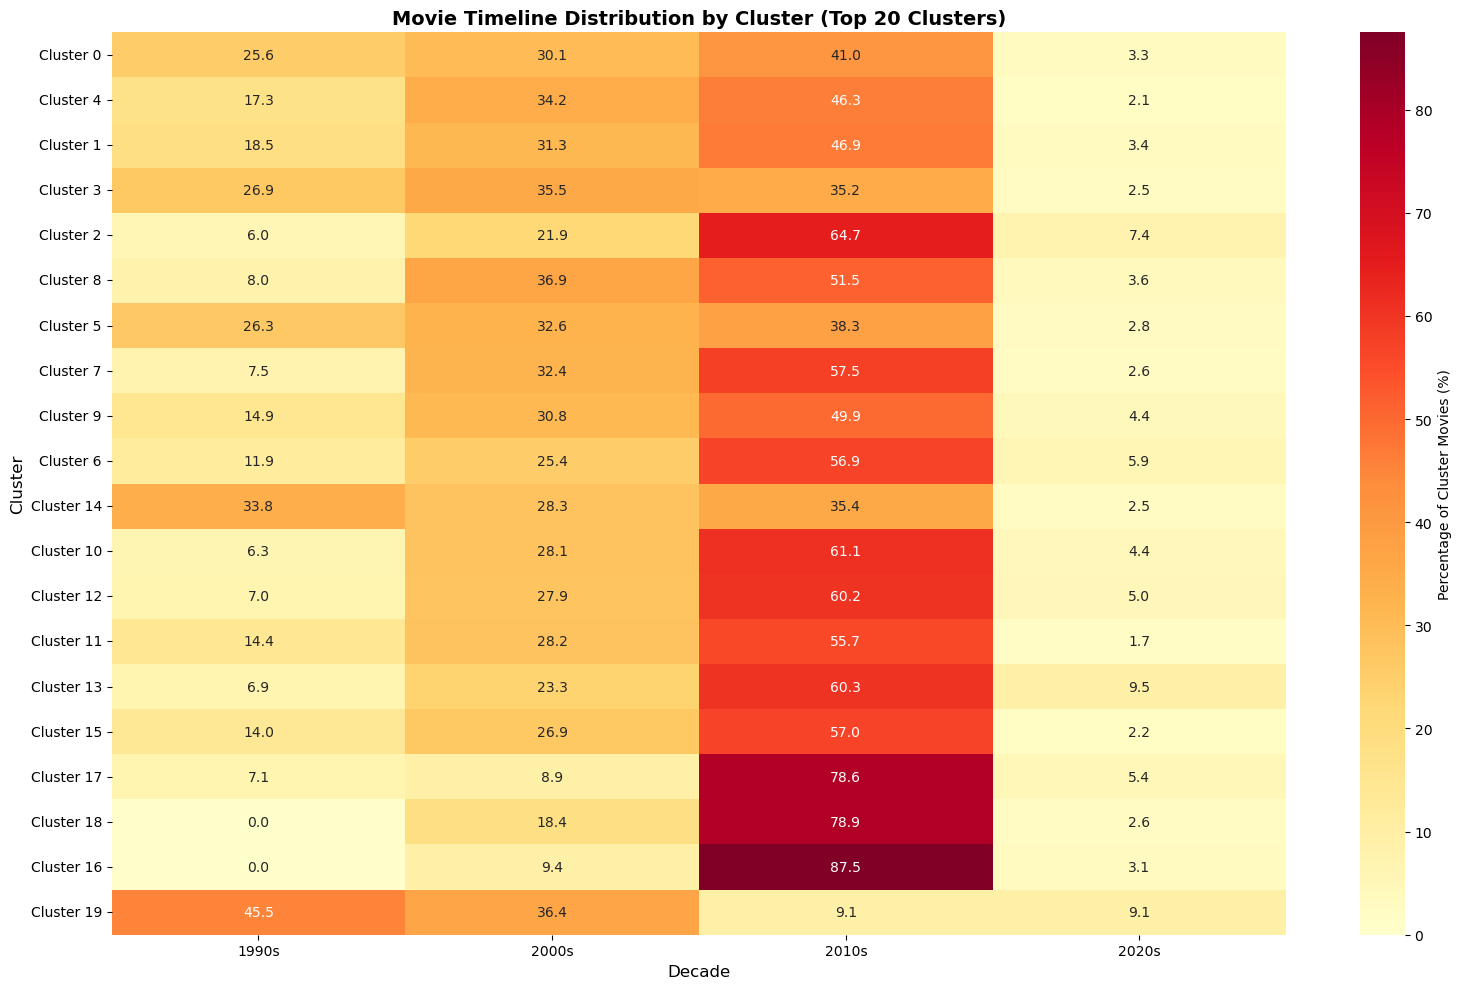

In [60]:
# Create timeline heatmap showing movie distribution by decade
fig_timeline = create_timeline_heatmap(cluster_unique_movies, output_file='cluster_timeline_heatmap.png', top_n=20)

In [61]:
# Display the time statistics DataFrame (sorted by number of movies)
df_time_stats.sort_values('num_movies', ascending=False).head(20)

cluster_id  num_movies  num_members  min_year  max_year    mean_year  \
0            0        4461         5509      1990      2021  2006.801166   
4            4        3028         2458      1990      2021  2008.043593   
1            1        2795         3648      1990      2021  2008.126297   
3            3        2488         3067      1990      2021  2005.881431   
2            2        2107         3404      1990      2021  2012.266730   
8            8         914          841      1990      2021  2009.919037   
5            5         797         1503      1990      2021  2006.410289   
7            7         765          860      1990      2021  2010.305882   
9            9         724          681      1990      2021  2009.017956   
6            6         631         1072      1990      2021  2010.757528   
14          14         364          300      1990      2021  2004.865385   
10          10         270          445      1992      2021  2011.518519   
12          12         201          309      1993      2021  2011.213930   
11          11         174          333      1990      2020  2009.511494   
13          13         116          301      1990      2021  2011.939655   
15          15          93          252      1990      2021  2010.000000   
17          17          56          100      1991      2020  2013.500000   
18          18          38           39      2004      2020  2013.473684   
16          16          32          154      2000      2020  2015.187500   
19          19          11           17      1993      2020  2002.272727   

    median_year  std_year  year_range  q1_year  q3_year  
0        2008.0  8.808794          31  1999.00  2015.00  
4        2009.0  7.915760          31  2002.00  2015.00  
1        2010.0  8.215096          31  2002.00  2015.00  
3        2006.0  8.451822          31  1999.00  2013.00  
2        2014.0  6.411905          31  2009.00  2017.00  
8        2011.0  6.709509          31  2005.00  2015.00  
5        2007.0  8.737122          31  1999.00  2014.00  
7        2012.0  6.742745          31  2006.00  2016.00  
9        2010.0  7.798460          31  2004.00  2015.00  
6        2013.0  7.505297          31  2007.00  2017.00  
14       2005.0  8.943412          31  1997.00  2013.00  
10       2013.0  6.477141          29  2008.00  2017.00  
12       2013.0  6.794716          28  2007.00  2017.00  
11       2011.0  7.813736          30  2005.25  2016.00  
13       2014.0  6.887381          31  2008.00  2017.00  
15       2013.0  7.918944          31  2006.00  2017.00  
17       2016.0  6.458660          29  2012.00  2018.00  
18       2014.5  4.146887          16  2011.25  2016.75  
16       2016.0  4.326066          20  2013.75  2018.00  
19       2000.0  8.645450          27  1996.50  2004.50